# Resource usage - exploratory analysis

#### Maria Silva, April 2025

## 1. Imports and settings

Let's start by importing the necessary libraries and setting up some directories and files.


In [1]:
import os
import sys
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")

In [2]:
# plotting theme
sns.set_theme(
    style="whitegrid", palette="Set2", rc={"figure.dpi": 500, "axes.titlesize": 15}
)

In [3]:
# Main directories and files
current_path = os.getcwd()
repo_dir = os.path.abspath(os.path.join(current_path, ".."))
src_dir = os.path.join(repo_dir, "src")
data_dir = os.path.join(repo_dir, "data")
op_files_dir = os.path.join(data_dir, "aggregated_opcodes_v3", "*", "file.parquet")

In [4]:
# import internal packages
sys.path.append(src_dir)
from data.gas_cost import compute_component_gas_costs_per_tx
from resource_gas_split import compute_resource_gas_cost_per_tx

## 2. Load data

Now, let's load the data. We will start by loading the opcodes used for blocks 22000000 to 22004000.

In [5]:
block_start = 22000000
block_end = 22004000
# Load parquet files with duckdb
query = f"""
SELECT *
FROM read_parquet(
    '{op_files_dir}', 
    hive_partitioning=True, 
    union_by_name=True
    )
WHERE block_height BETWEEN {block_start} AND {block_end};
"""
agg_trace_df = duckdb.connect().execute(query).fetchdf()
# Drop columns
agg_trace_df = agg_trace_df.drop(columns=["block_range"])
# Clean up repeated opcodes
agg_trace_df["op"] = np.where(
    agg_trace_df["op"].str.startswith("DUP"), "DUP", agg_trace_df["op"]
)
agg_trace_df["op"] = np.where(
    agg_trace_df["op"].str.startswith("SWAP"), "SWAP", agg_trace_df["op"]
)
agg_trace_df["op"] = np.where(
    (agg_trace_df["op"].str.startswith("PUSH")) & (agg_trace_df["op"] != "PUSH0"),
    "PUSH",
    agg_trace_df["op"],
)
# Compute total gas cost for opcode
agg_trace_df["op_total_gas_cost"] = (
    agg_trace_df["op_gas_cost"] * agg_trace_df["op_gas_pair_count"]
)
# Print info
agg_trace_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60809234 entries, 0 to 60809233
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   block_height       int64  
 1   tx_hash            object 
 2   op                 object 
 3   op_gas_cost        float64
 4   post_memory_size   int64  
 5   memory_expansion   int64  
 6   memory_size        int64  
 7   cum_refund         int64  
 8   call_address       object 
 9   op_gas_pair_count  int64  
 10  op_total_gas_cost  float64
dtypes: float64(2), int64(6), object(3)
memory usage: 5.0+ GB


In [6]:
agg_trace_df["block_height"].agg(["min", "max"])

min    22000000
max    22004000
Name: block_height, dtype: int64

Now, we can load the gas used per transaction.

In [7]:
# Load parquet file
tx_gas_info_df = pd.read_parquet(
    os.path.join(data_dir, "tx_gas_usage_22000000_22006000.parquet")
)
# Make sure we don't more blocks than agg_trace_df
tx_gas_info_df = tx_gas_info_df[
    tx_gas_info_df["block_height"].between(
        agg_trace_df["block_height"].min(), agg_trace_df["block_height"].max()
    )
]
# Print info
tx_gas_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 636134 entries, 0 to 636133
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   block_height            636134 non-null  int64 
 1   tx_hash                 636134 non-null  object
 2   tx_gas_cost             636134 non-null  int64 
 3   tx_gas_limit            636134 non-null  int64 
 4   tx_input_zero_bytes     636134 non-null  int64 
 5   tx_input_nonzero_bytes  636134 non-null  int64 
 6   tx_input_data_cost      636134 non-null  int64 
 7   is_contract_creation    636134 non-null  bool  
 8   is_success              636134 non-null  bool  
dtypes: bool(2), int64(6), object(1)
memory usage: 40.0+ MB


## 3. Process data

In [8]:
# Compute gas costs by component
comp_df = compute_component_gas_costs_per_tx(agg_trace_df, tx_gas_info_df)
comp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636134 entries, 0 to 636133
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   block_height           636134 non-null  int64  
 1   tx_hash                636134 non-null  object 
 2   total_gas_cost         636134 non-null  int64  
 3   input_data_cost        636134 non-null  int64  
 4   intrinsic_base_cost    636134 non-null  float64
 5   op_gas_cost            636134 non-null  float64
 6   gas_refund             636134 non-null  float64
 7   intrinsic_access_cost  636134 non-null  float64
dtypes: float64(4), int64(3), object(1)
memory usage: 38.8+ MB


In [9]:
# How many transactions with strange intrinsic access costs?
strange_access_txs = comp_df[~comp_df["intrinsic_access_cost"].between(0, 4000000)][
    "tx_hash"
].values.tolist()
gas_perc = (
    comp_df[comp_df["tx_hash"].isin(strange_access_txs)]["total_gas_cost"].sum()
) / (comp_df["total_gas_cost"].sum())

print("tx %:", np.round(100 * len(strange_access_txs) / len(comp_df), 2))
print("gas %:", np.round(gas_perc * 100, 2))

tx %: 0.21
gas %: 0.99


In [10]:
# How many failed transactions?
fail_txs = tx_gas_info_df[~tx_gas_info_df["is_success"]]["tx_hash"].values.tolist()
gas_perc = (comp_df[comp_df["tx_hash"].isin(fail_txs)]["total_gas_cost"].sum()) / (
    comp_df["total_gas_cost"].sum()
)

print("tx %:", np.round(100 * len(fail_txs) / len(comp_df), 2))
print("gas %:", np.round(gas_perc * 100, 2))

tx %: 1.71
gas %: 1.85


In [11]:
# Compute gas cost by resource
# fail_txs and strange_access_txs are unassigned...
ignore_txs = fail_txs + strange_access_txs
gas_by_resource_df = compute_resource_gas_cost_per_tx(
    agg_trace_df,
    tx_gas_info_df,
    comp_df,
    ignore_txs,
)
gas_by_resource_df.head()

tx_hash  Compute   Access  \
0  0x00001c22225afea789e63b4860d8f80869a21bf33eab...      0.0      0.0   
1  0x0000322a0cadcee269a3cb6c6335d1013b1a0121b8d9...  11653.0  14300.0   
2  0x00003ef2732f7a5fae9e941735730033b0b9158f352d...  12192.0  12800.0   
3  0x00003ffccb5b6e1e0d693a887bd6c098162e764ddcfc...   8500.0    300.0   
4  0x0000660566258dcad219705056675861f779e7726e52...  15616.0   2800.0   

   Memory  History  Bloom topics   State  Bandwidth  Unassigned  block_height  \
0     0.0      0.0           0.0     0.0        0.0    194866.0           NaN   
1    12.0   7646.0         750.0  5600.0     6148.0         0.0    22003018.0   
2    24.0   7646.0         750.0   800.0     6148.0         0.0    22000219.0   
3     0.0   6660.0           0.0     0.0     6052.0         0.0    22002582.0   
4    24.0   7908.0         250.0     0.0     6052.0         0.0    22000622.0   

   State (exc. Refunds)  
0                   NaN  
1                5600.0  
2                5600.0  
3                   0.0  
4                   0.0

In [12]:
# Melt (for plotting)
melt_gas_by_resource_df = gas_by_resource_df.melt(
    id_vars=["block_height", "tx_hash"], var_name="Resource", value_name="gas_cost"
).sort_values("Resource")

melt_gas_by_resource_df.head()

block_height                                            tx_hash  \
954200    22000084.0  0x7ff6375aa4a30606b21afa90b28e0045fc9c41deb3e2...   
848183    22001709.0  0x5586a78d3edd080b91a147a23e6d1b6abe829133817d...   
848182    22002116.0  0x558653fb2a25ff7ee43882854052b6d4ce9ac8af8784...   
848181    22003138.0  0x5586435e02d080a40bb9efeafa23646c1ba4d57c9ed5...   
848180    22001354.0  0x55860a8c5aab699bc3ae361ab896de9e80744b2c6ccb...   

       Resource  gas_cost  
954200   Access   14300.0  
848183   Access    4800.0  
848182   Access     300.0  
848181   Access   43000.0  
848180   Access     300.0

## 4. Analyze gas by resource

In [13]:
# Transactions with unassigned gas
total_gas = (
    gas_by_resource_df.drop(columns=["tx_hash", "block_height", "State (exc. Refunds)"])
    .sum(axis=1)
    .sum()
)
print(
    "Txs %:", 100 * sum(gas_by_resource_df["Unassigned"] > 0) / len(gas_by_resource_df)
)
print("Gas:", gas_by_resource_df["Unassigned"].sum())
print("Gas %:", 100 * gas_by_resource_df["Unassigned"].sum() / total_gas)

Txs %: 1.7802852858045632
Gas: 1948605906.0
Gas %: 2.6683833791341525


In [14]:
# What percentage of transactions have a positive intrinsic costs?
100 * sum(comp_df["intrinsic_access_cost"] > 0) / len(comp_df)

9.349916841420203

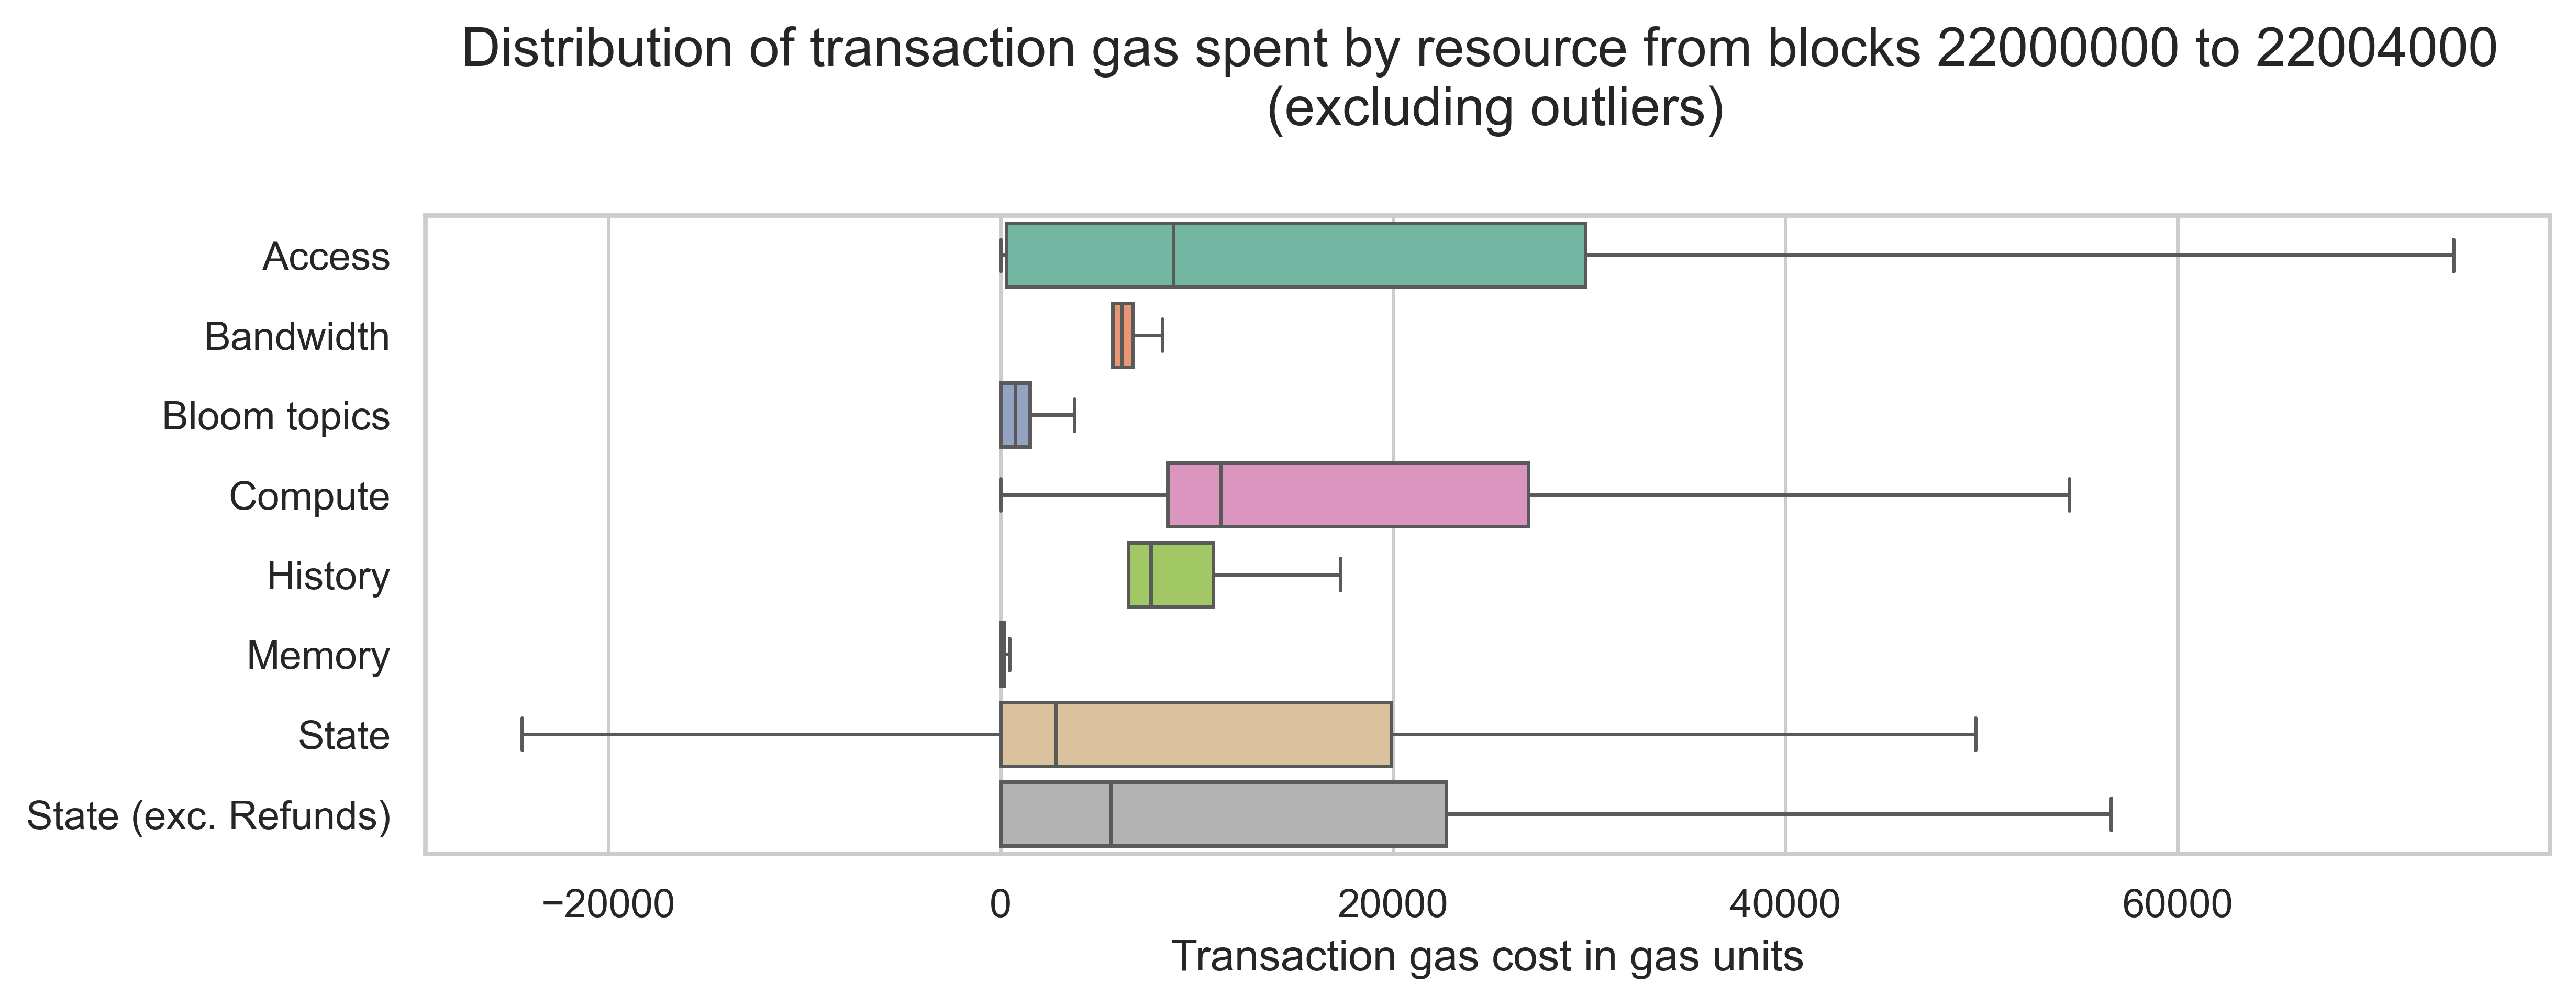

In [15]:
plt.figure(figsize=(10, 4))
sns.boxplot(
    y="Resource",
    x="gas_cost",
    data=melt_gas_by_resource_df[melt_gas_by_resource_df["Resource"] != "Unassigned"],
    hue="Resource",
    legend=False,
    showfliers=False,
)
plt.title(
    f"Distribution of transaction gas spent by resource from blocks {block_start} to {block_end} \n (excluding outliers)",
    pad=25,
)
plt.ylabel("")
plt.xlabel("Transaction gas cost in gas units")
plt.tight_layout()
plt.show()

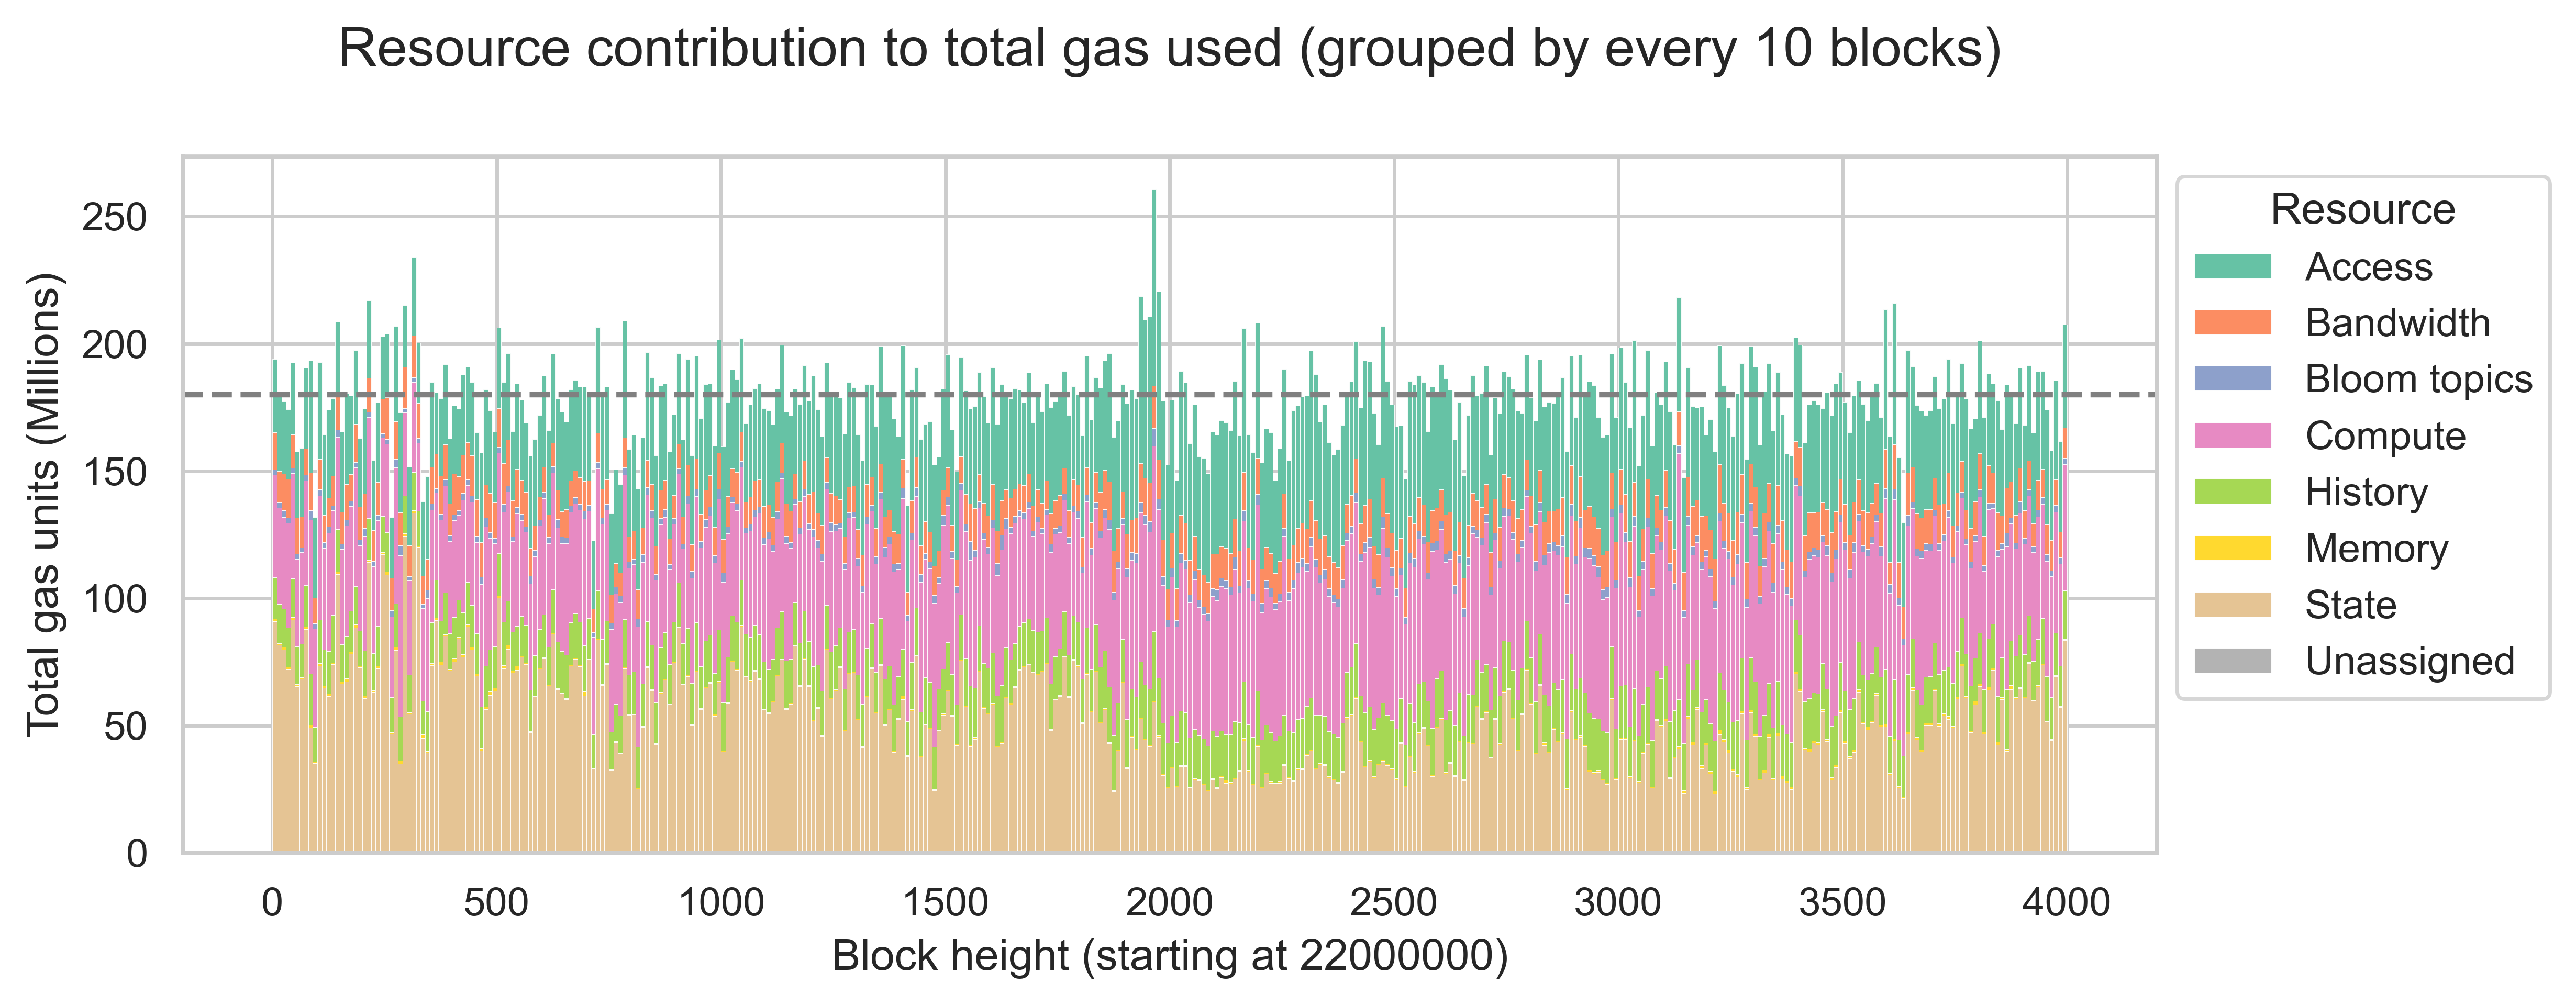

In [16]:
temp_df = (
    melt_gas_by_resource_df[
        melt_gas_by_resource_df["Resource"] != "State (exc. Refunds)"
    ]
    .groupby(["block_height", "Resource"])["gas_cost"]
    .sum()
    / 1_000_000
)
temp_df = temp_df.reset_index().sort_values("Resource")
temp_df["block_height"] = temp_df["block_height"] - 22000000

plt.figure(figsize=(10, 4))
ax = sns.histplot(
    temp_df,
    x="block_height",
    weights="gas_cost",
    hue="Resource",
    multiple="stack",
    binwidth=10,
    alpha=1.0,
)
plt.title(
    "Resource contribution to total gas used (grouped by every 10 blocks)",
    pad=25,
)
plt.xlabel("Block height (starting at 22000000)")
plt.ylabel("Total gas units (Millions)")
plt.axhline(y=180, color="grey", linestyle="--", label="target block size")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [17]:
temp_df = (
    melt_gas_by_resource_df[
        melt_gas_by_resource_df["Resource"] != "State (exc. Refunds)"
    ]
    .groupby(["Resource"])["gas_cost"]
    .sum()
    / 1_000_000
)
print(temp_df.sort_values(ascending=False))
print(temp_df.sort_values(ascending=False) / temp_df.sum())

Resource
State           21337.256122
Compute         19706.304720
Access          16237.989461
History          7225.616780
Bandwidth        5156.618100
Unassigned       1948.605906
Bloom topics     1162.808000
Memory            250.510830
Name: gas_cost, dtype: float64
Resource
State           0.292188
Compute         0.269854
Access          0.222360
History         0.098946
Bandwidth       0.070614
Unassigned      0.026684
Bloom topics    0.015923
Memory          0.003430
Name: gas_cost, dtype: float64


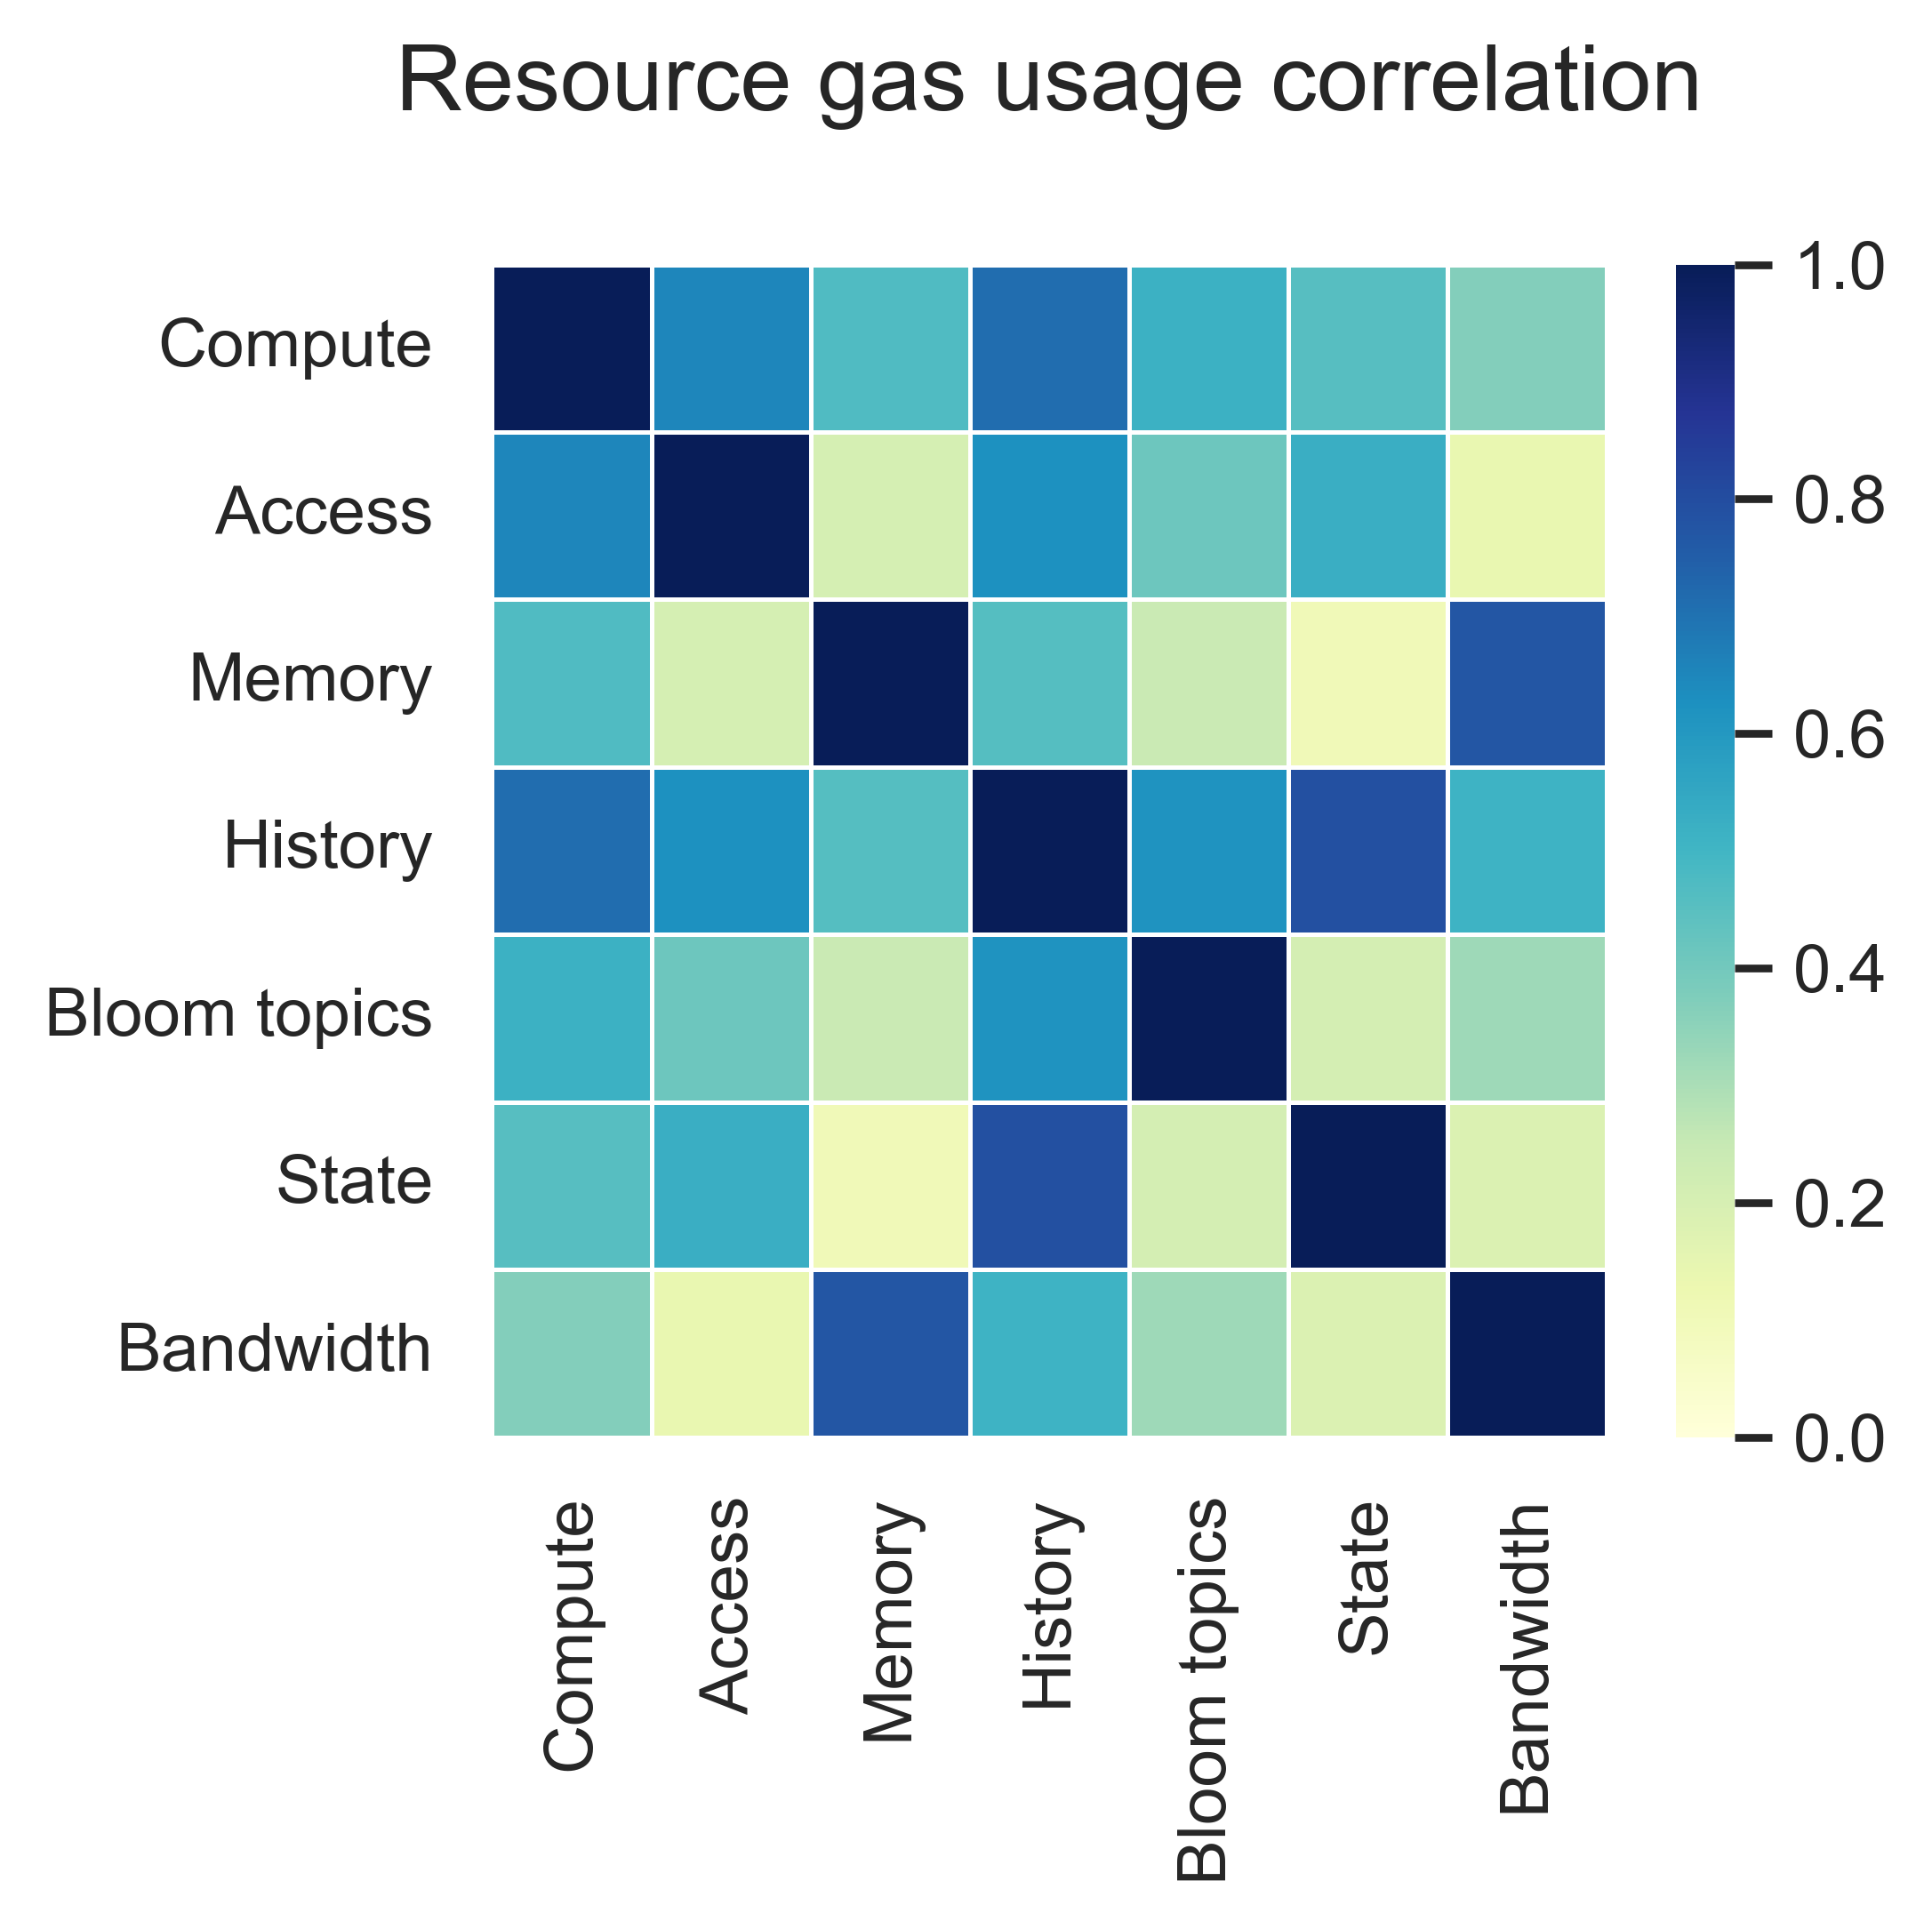

In [18]:
temp_df = gas_by_resource_df.drop(
    columns=["block_height", "Unassigned", "State (exc. Refunds)"]
).set_index("tx_hash")
corr_mat = temp_df.corr()
plt.figure(figsize=(4.5, 4.5))
ax = sns.heatmap(corr_mat, cmap="YlGnBu", linewidths=0.5, vmin=0, vmax=1)
plt.title("Resource gas usage correlation", pad=25)
plt.tight_layout()
plt.show()

## 5. Analyze block utilization

In [19]:
totals_df = (
    gas_by_resource_df.drop(columns=["tx_hash", "State (exc. Refunds)"])
    .groupby("block_height")
    .sum()
)
totals_df.head()

Compute     Access    Memory    History  Bloom topics  \
block_height                                                            
22000000.0    2489521.0  2388848.0   38438.0  1234279.5      149500.0   
22000001.0    6641783.0  2759899.0  330132.0  2071252.0      267750.0   
22000002.0    3271744.0  2827479.0   50038.0  1264452.0      173250.0   
22000003.0    3979104.0  2997615.0   24050.0  1647246.0      185250.0   
22000004.0    2635728.0  1886444.0   40126.0  1578321.5      149000.0   

                   State  Bandwidth  Unassigned  
block_height                                     
22000000.0    11582506.0  1252477.5         0.0  
22000001.0     1932300.0  2258159.0         0.0  
22000002.0     9393240.0  1154862.0         0.0  
22000003.0     2215800.0  1314686.0         0.0  
22000004.0    18424296.0  1293454.5         0.0

In [20]:
# One dimensional metering
one_dim_df = totals_df.sum(axis=1).reset_index()
one_dim_df.columns = ["block_height", "usage"]
one_dim_df["perc_over_limit"] = one_dim_df["usage"] / 36_000_000
one_dim_df["utilization"] = (one_dim_df["usage"] - 18_000_000) / 18_000_000
one_dim_df["meter"] = "Unidimensional"
one_dim_df = one_dim_df.reset_index()

# Two dimensional -  State & History vs. others
two_dim_df = pd.DataFrame(
    {
        "state_history": totals_df["State"] + totals_df["History"],
        "others": totals_df.sum(axis=1) - totals_df["State"] - totals_df["History"],
    }
)
two_dim_df["usage"] = two_dim_df.max(axis=1)
two_dim_df["perc_over_limit"] = two_dim_df["usage"] / 36_000_000
two_dim_df["utilization"] = (two_dim_df["usage"] - 18_000_000) / 18_000_000
two_dim_df["meter"] = "State/history vs. Others"
two_dim_df = two_dim_df.reset_index()

# Two dimensional -  State & History vs. Storage Access vs. others
three_dim_df = pd.DataFrame(
    {
        "state_history": totals_df["State"] + totals_df["History"],
        "access": totals_df["Access"],
        "others": totals_df.sum(axis=1)
        - totals_df["State"]
        - totals_df["History"]
        - totals_df["Access"],
    }
)
three_dim_df["usage"] = three_dim_df.max(axis=1)
three_dim_df["perc_over_limit"] = three_dim_df["usage"] / 36_000_000
three_dim_df["utilization"] = (three_dim_df["usage"] - 18_000_000) / 18_000_000
three_dim_df["meter"] = "State/history vs. Access vs. Others"
three_dim_df = three_dim_df.reset_index()

# Aggregate all dataframes
util_melt_df = pd.concat(
    [
        one_dim_df[
            ["block_height", "meter", "usage", "perc_over_limit", "utilization"]
        ],
        two_dim_df[
            ["block_height", "meter", "usage", "perc_over_limit", "utilization"]
        ],
        three_dim_df[
            ["block_height", "meter", "usage", "perc_over_limit", "utilization"]
        ],
    ],
    ignore_index=True,
)
util_melt_df.head()

block_height           meter       usage  perc_over_limit  utilization
0    22000000.0  Unidimensional  19135570.0         0.531544     0.063087
1    22000001.0  Unidimensional  16261275.0         0.451702    -0.096596
2    22000002.0  Unidimensional  18135065.0         0.503752     0.007504
3    22000003.0  Unidimensional  12363751.0         0.343438    -0.313125
4    22000004.0  Unidimensional  26007370.0         0.722427     0.444854

In [21]:
((two_dim_df["usage"] - one_dim_df["usage"]) / one_dim_df["usage"]).agg(
    ["mean", "median"]
)

mean     -0.311963
median   -0.297345
Name: usage, dtype: float64

In [22]:
((three_dim_df["usage"] - two_dim_df["usage"]) / two_dim_df["usage"]).agg(
    ["mean", "median"]
)

mean     -0.297021
median   -0.365702
Name: usage, dtype: float64

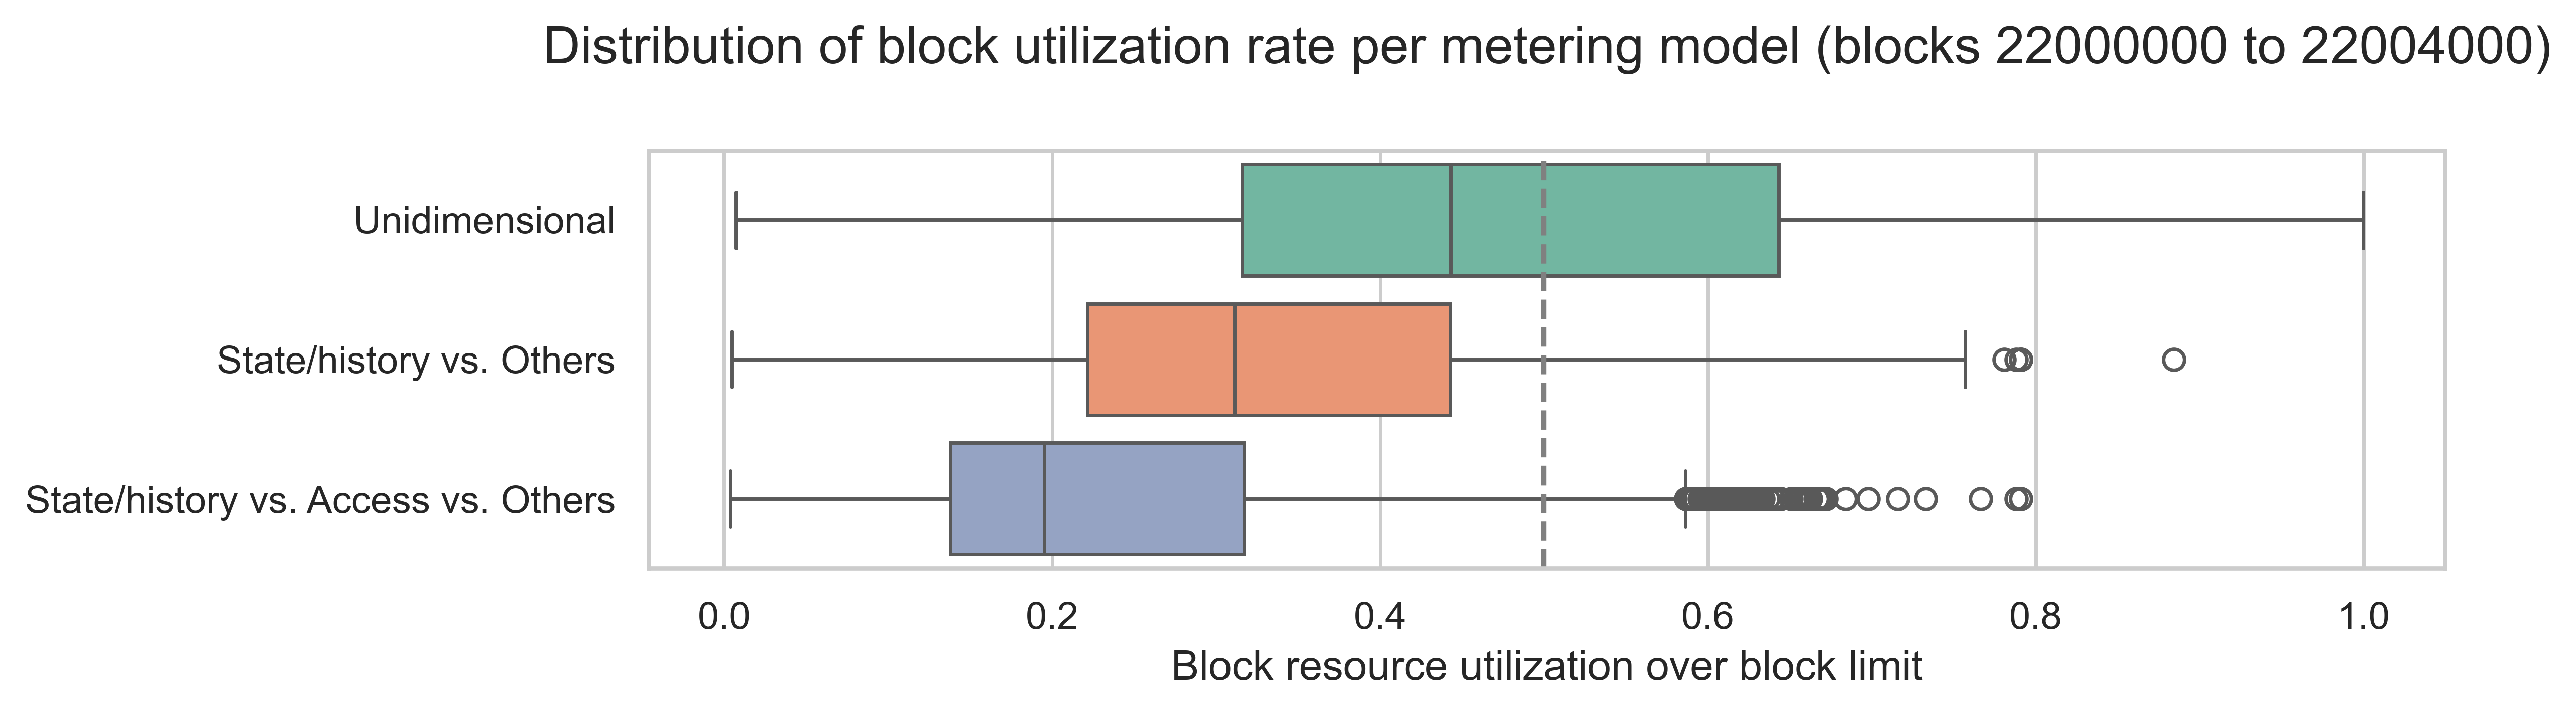

In [23]:
plt.figure(figsize=(10, 3))
sns.boxplot(
    data=util_melt_df,
    x="perc_over_limit",
    y="meter",
    hue="meter",
    legend=False,
)
plt.axvline(x=0.5, color="grey", linestyle="--")
plt.xlabel("Block resource utilization over block limit")
plt.ylabel("")
plt.title(
    f"Distribution of block utilization rate per metering model (blocks {block_start} to {block_end})",
    pad=25,
)
plt.tight_layout()
plt.show()

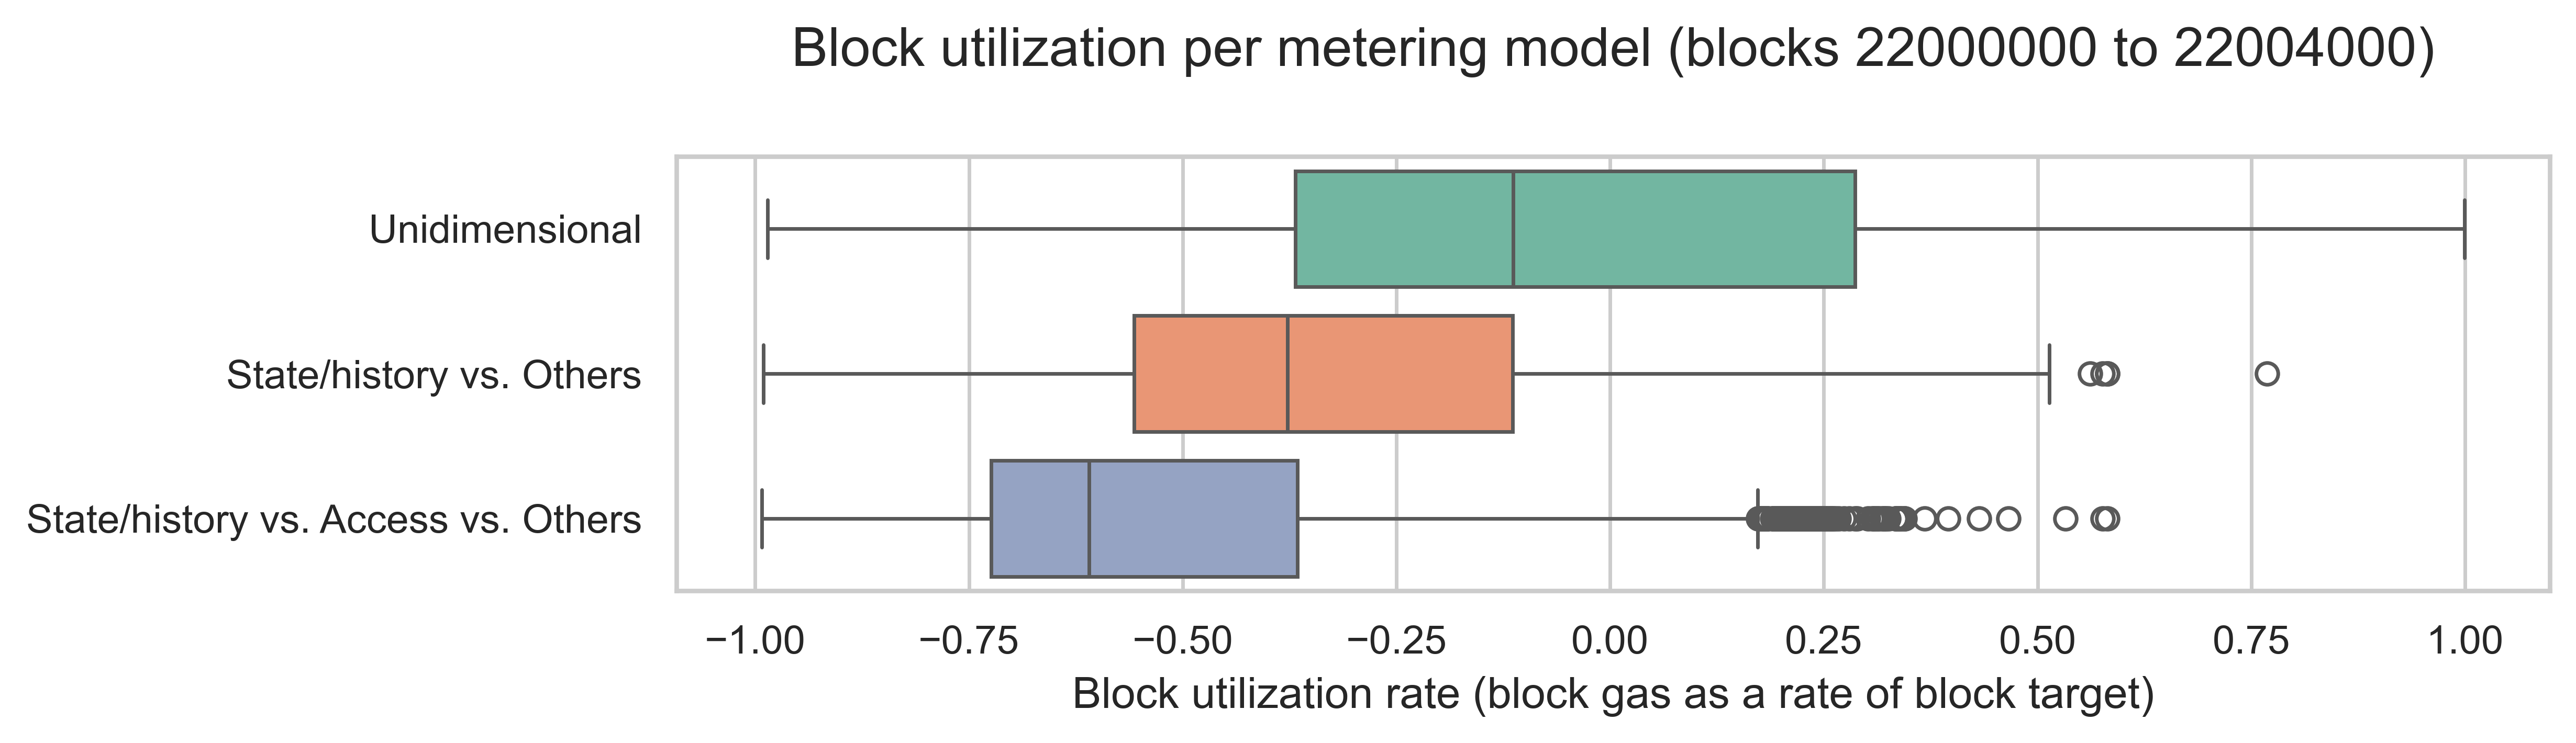

In [24]:
plt.figure(figsize=(10, 3))
sns.boxplot(
    data=util_melt_df,
    x="utilization",
    y="meter",
    hue="meter",
    legend=False,
)
plt.xlabel("Block utilization rate (block gas as a rate of block target)")
plt.ylabel("")
plt.title(f"Block utilization per metering model (blocks {block_start} to {block_end})", pad=25)
plt.tight_layout()
plt.show()

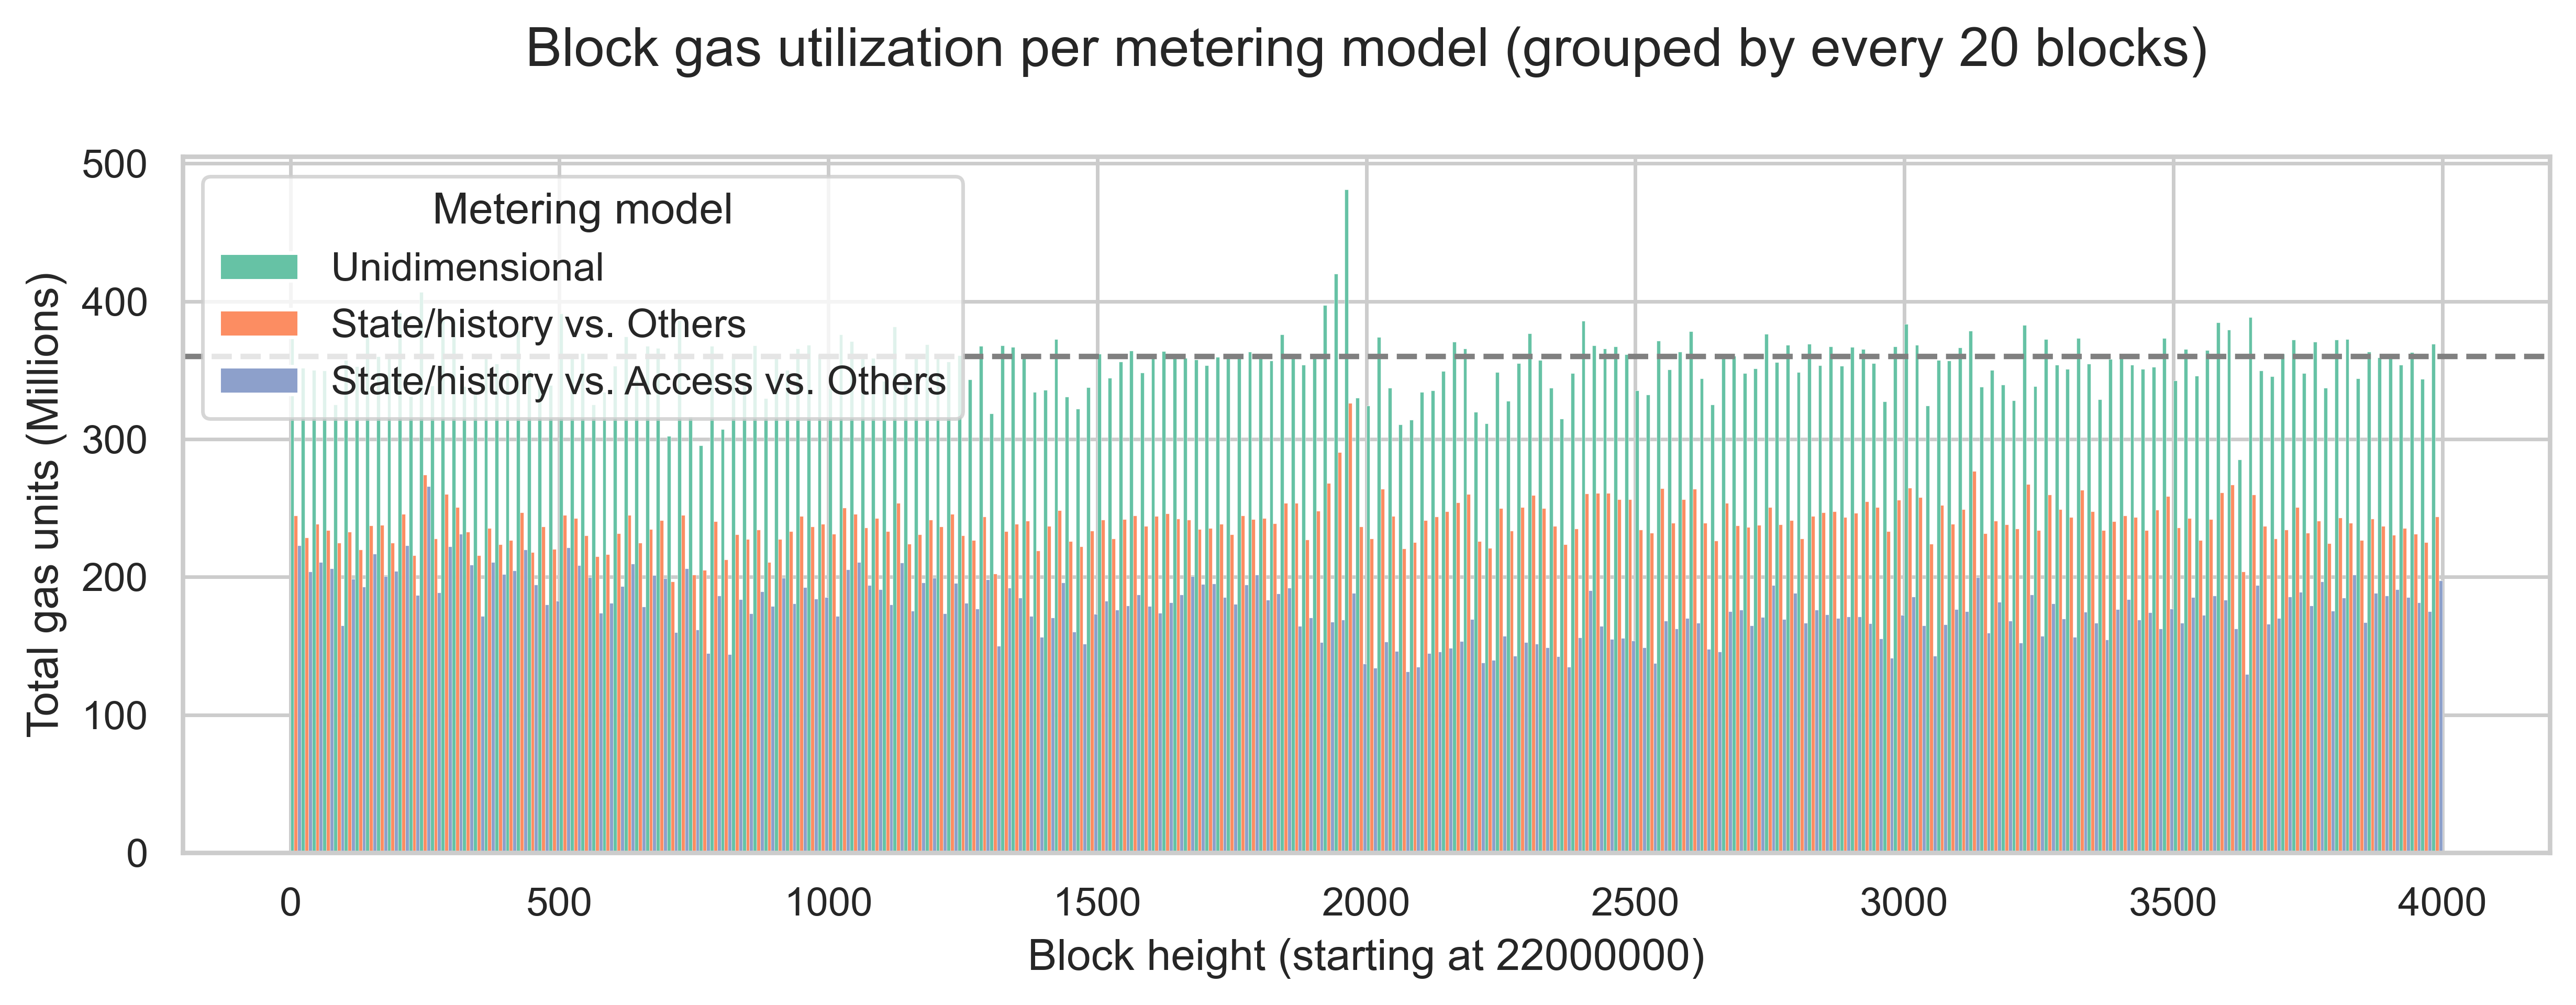

In [25]:
temp_df = util_melt_df.rename(columns={"meter": "Metering model"}).copy()
temp_df["usage"] = temp_df["usage"] / 1_000_000
temp_df["block_height"] = temp_df["block_height"] - 22000000

plt.figure(figsize=(10, 4))
ax = sns.histplot(
    temp_df,
    x="block_height",
    weights="usage",
    hue="Metering model",
    multiple="dodge",
    binwidth=20,
    alpha=1.0,
)
plt.title(
    "Block gas utilization per metering model (grouped by every 20 blocks)",
    pad=25,
)
plt.xlabel("Block height (starting at 22000000)")
plt.ylabel("Total gas units (Millions)")
plt.axhline(y=180 * 2, color="grey", linestyle="--", label="target block size")

plt.tight_layout()
plt.show()

## 6. Analyze resource utilization

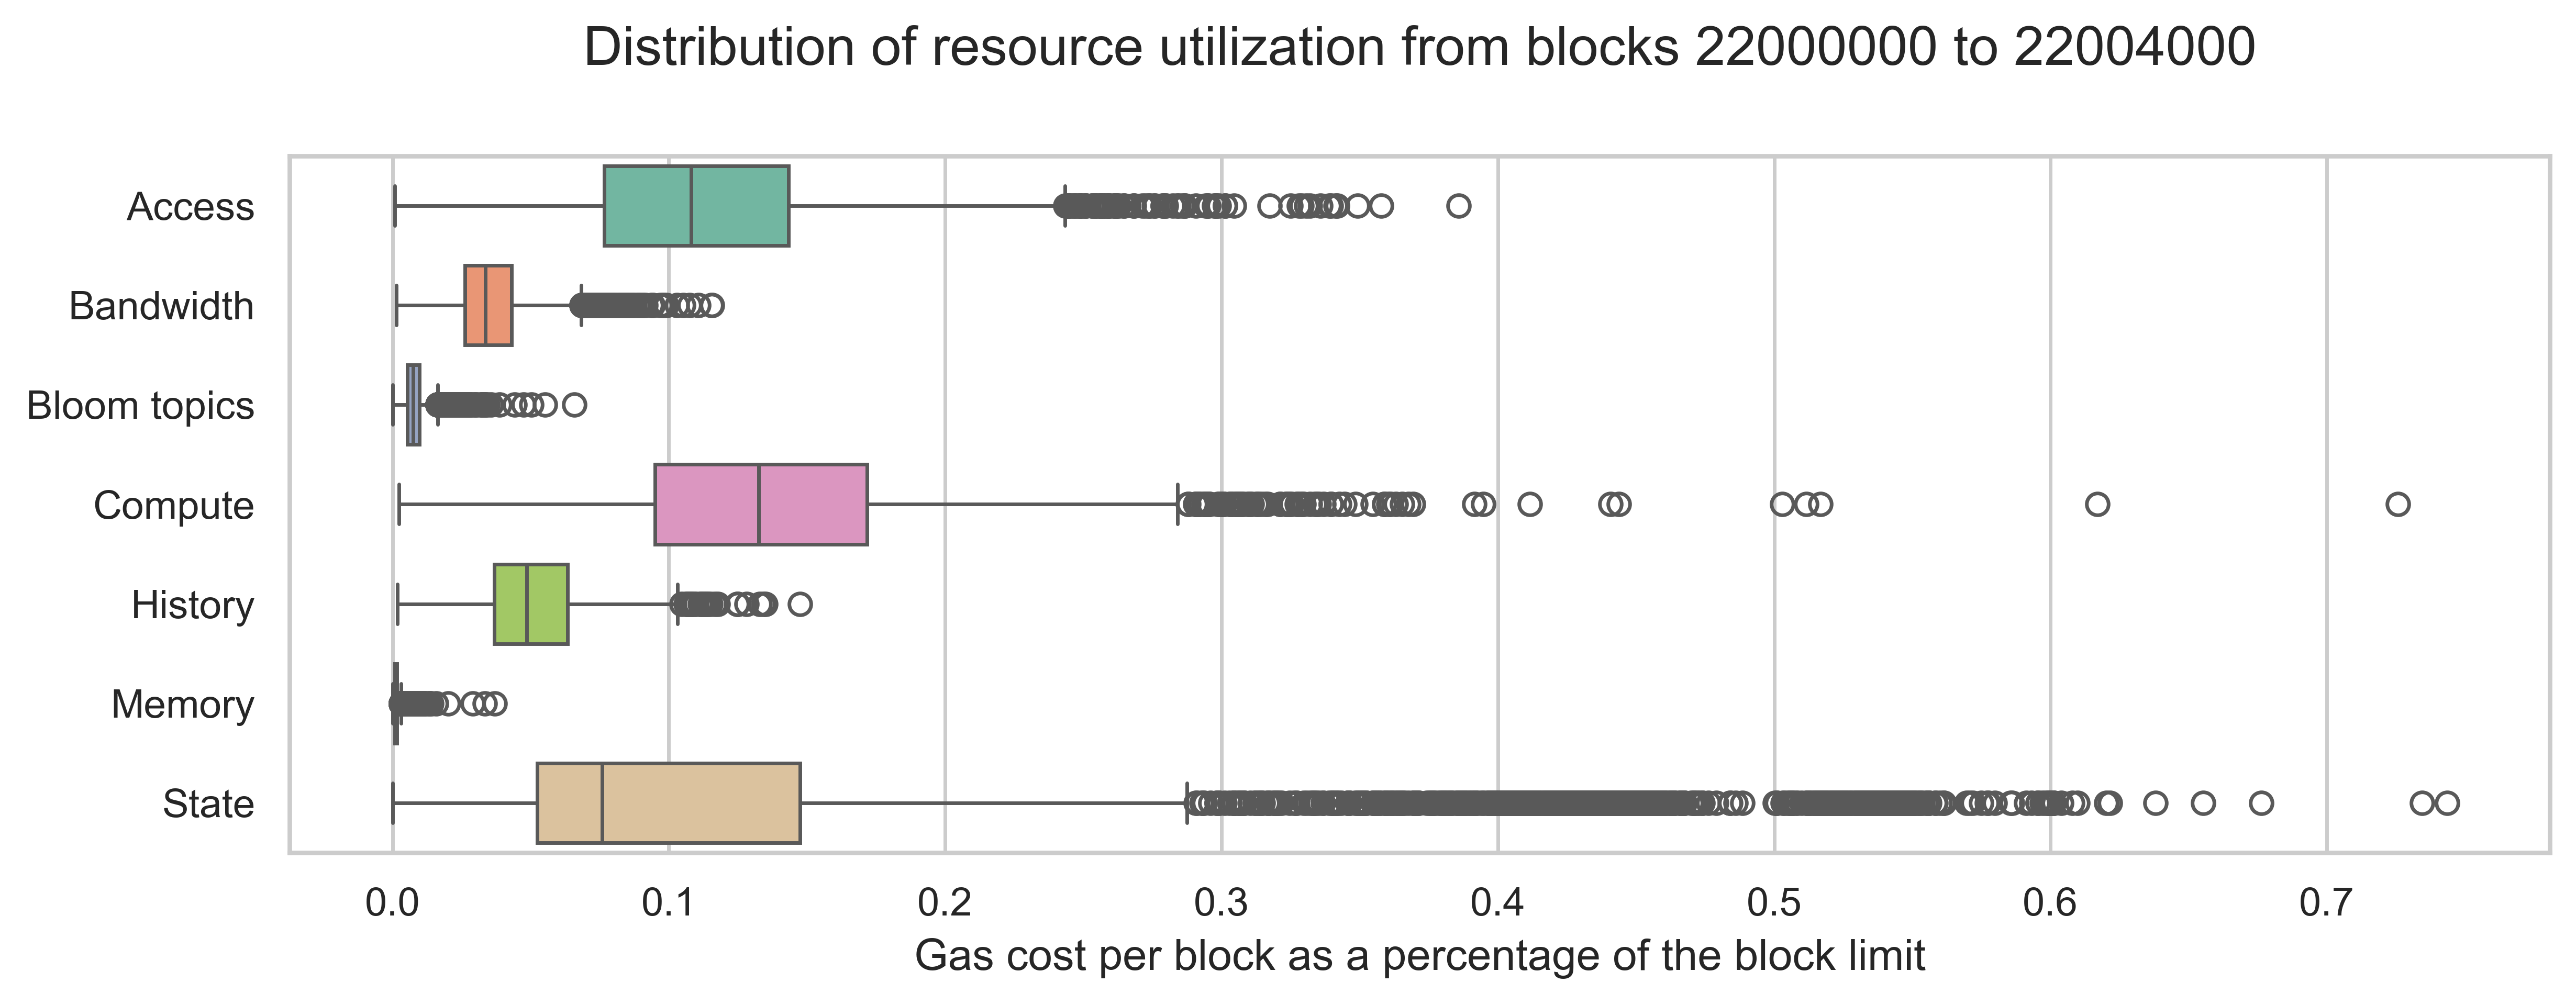

In [26]:
temp_df = (
    melt_gas_by_resource_df[
        ~melt_gas_by_resource_df["Resource"].isin(["Unassigned", "State (exc. Refunds)"])
    ]
    .groupby(["block_height", "Resource"])["gas_cost"]
    .sum()
    .reset_index()
)
temp_df["gas_cost"] = temp_df["gas_cost"] / 36_000_000

plt.figure(figsize=(10, 4))
sns.boxplot(
    y="Resource",
    x="gas_cost",
    data=temp_df,
    hue="Resource",
    legend=False,
)
plt.title(
    f"Distribution of resource utilization from blocks {block_start} to {block_end}",
    pad=25,
)
plt.ylabel("")
plt.xlabel("Gas cost per block as a percentage of the block limit")
plt.tight_layout()
plt.show()

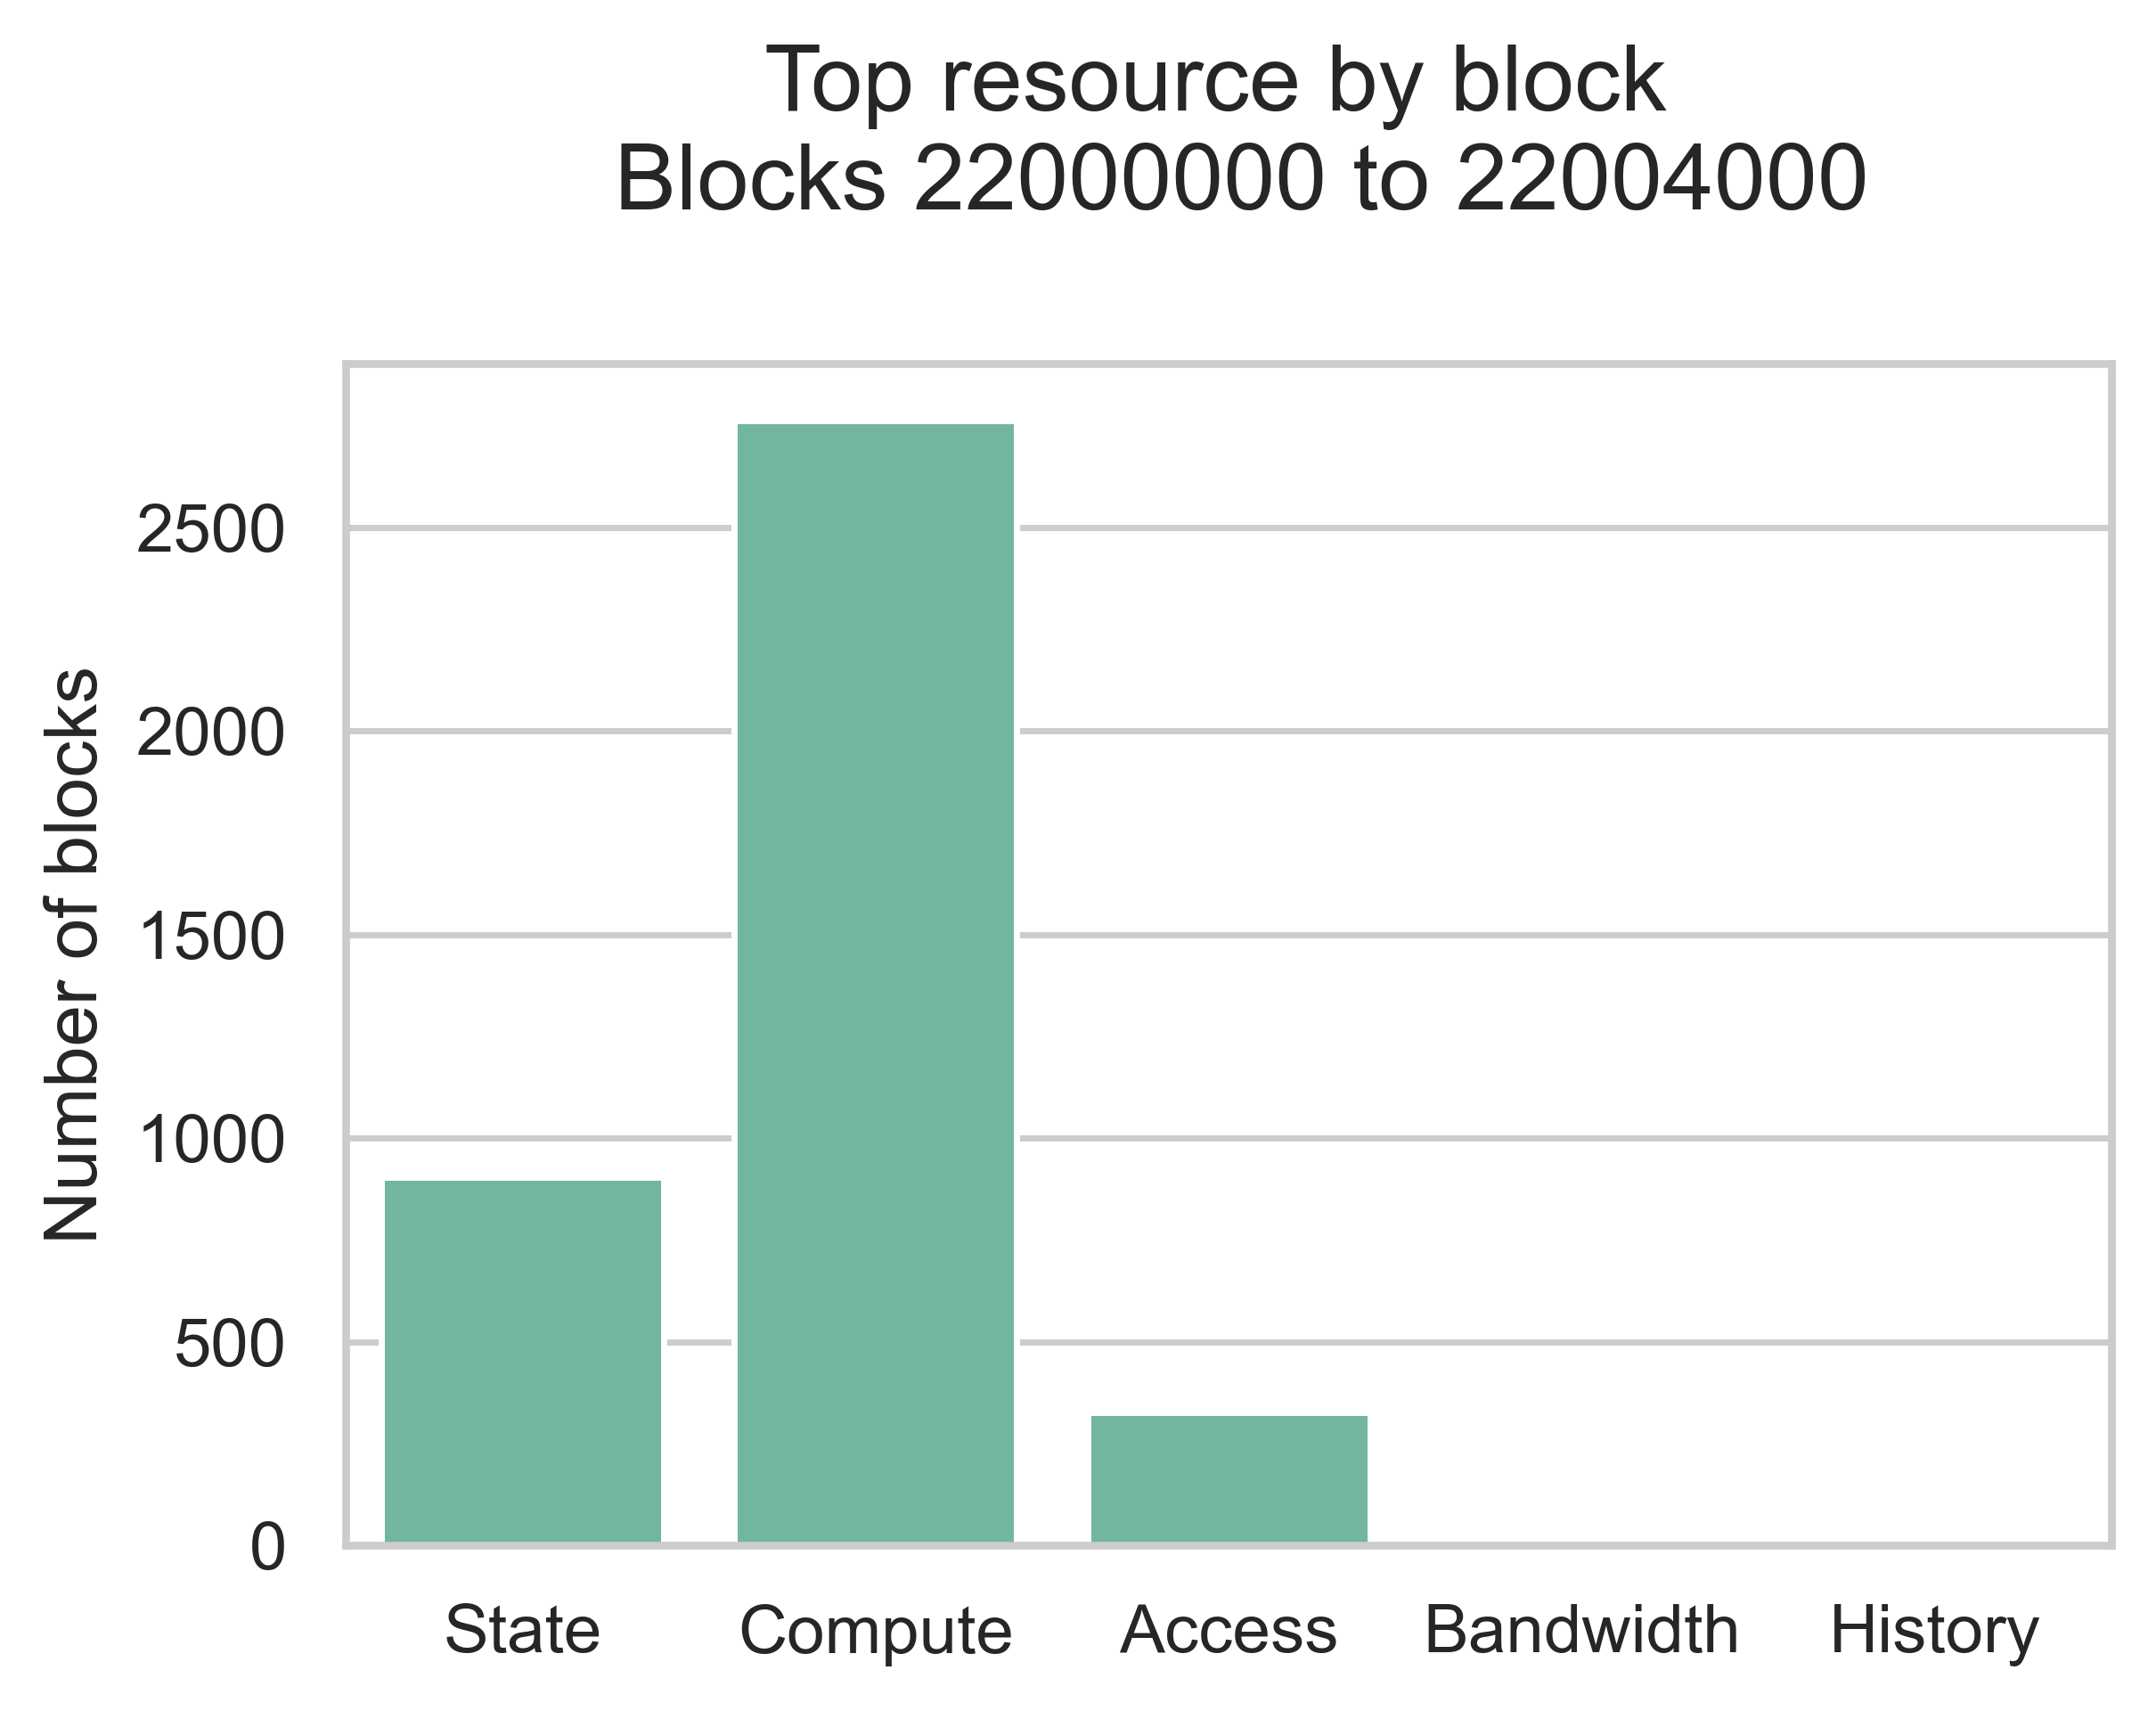

In [27]:
top_resource_df = (
    (totals_df / 36_000_000)
    .reset_index()
    .melt(id_vars=["block_height"], var_name="Resource", value_name="gas_cost")
    .sort_values("gas_cost", ascending=False)
    .groupby("block_height")
    .first()
)
plt.figure(figsize=(5, 4))
sns.countplot(data=top_resource_df, x="Resource")
plt.title(
    f"Top resource by block \n Blocks {block_start} to {block_end}",
    pad=25,
)
plt.xlabel("")
plt.ylabel("Number of blocks")
plt.tight_layout()
plt.show()

## 7. High utilization blocks

In [28]:
resource_by_block_df = totals_df.copy()
resource_by_block_df["Total"] = resource_by_block_df.sum(axis=1)
resource_by_block_df = resource_by_block_df / 36_000_000

Tx %: 40.565565565565564


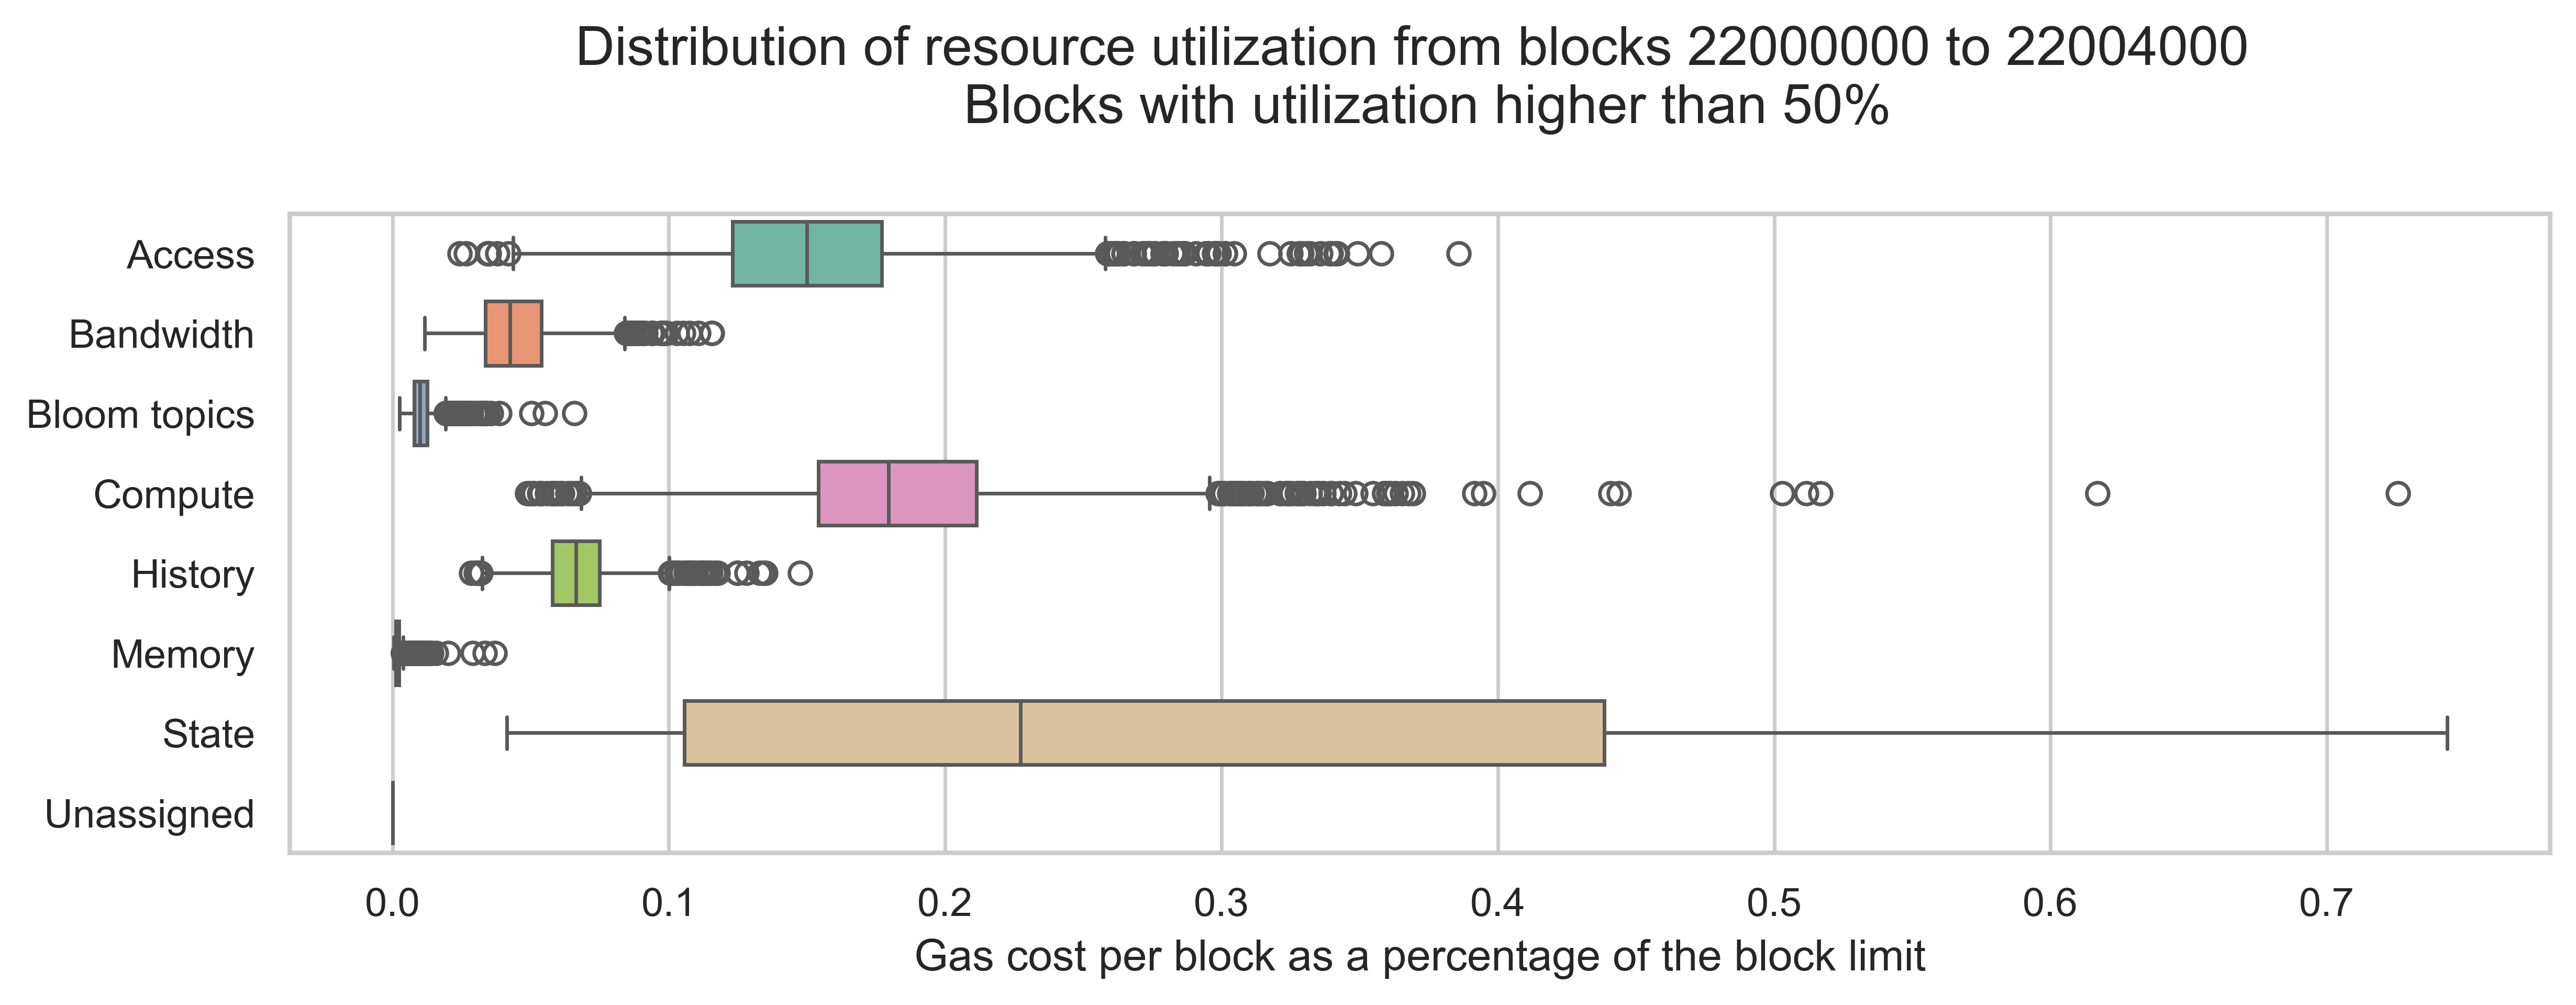

In [29]:
thres = 0.5
high_util_blocks_df = resource_by_block_df[resource_by_block_df["Total"] > thres]
print("Tx %:", 100 * len(high_util_blocks_df) / len(resource_by_block_df))

temp_df = (
    high_util_blocks_df.drop(columns="Total")
    .reset_index()
    .melt(id_vars=["block_height"], var_name="Resource", value_name="gas_cost")
    .sort_values("Resource")
)

plt.figure(figsize=(10, 4))
sns.boxplot(
    y="Resource",
    x="gas_cost",
    data=temp_df,
    hue="Resource",
    legend=False,
)
plt.title(
    f"Distribution of resource utilization from blocks {block_start} to {block_end} \n Blocks with utilization higher than {int(thres*100)}%",
    pad=25,
)
plt.ylabel("")
plt.xlabel("Gas cost per block as a percentage of the block limit")
plt.tight_layout()
plt.show()

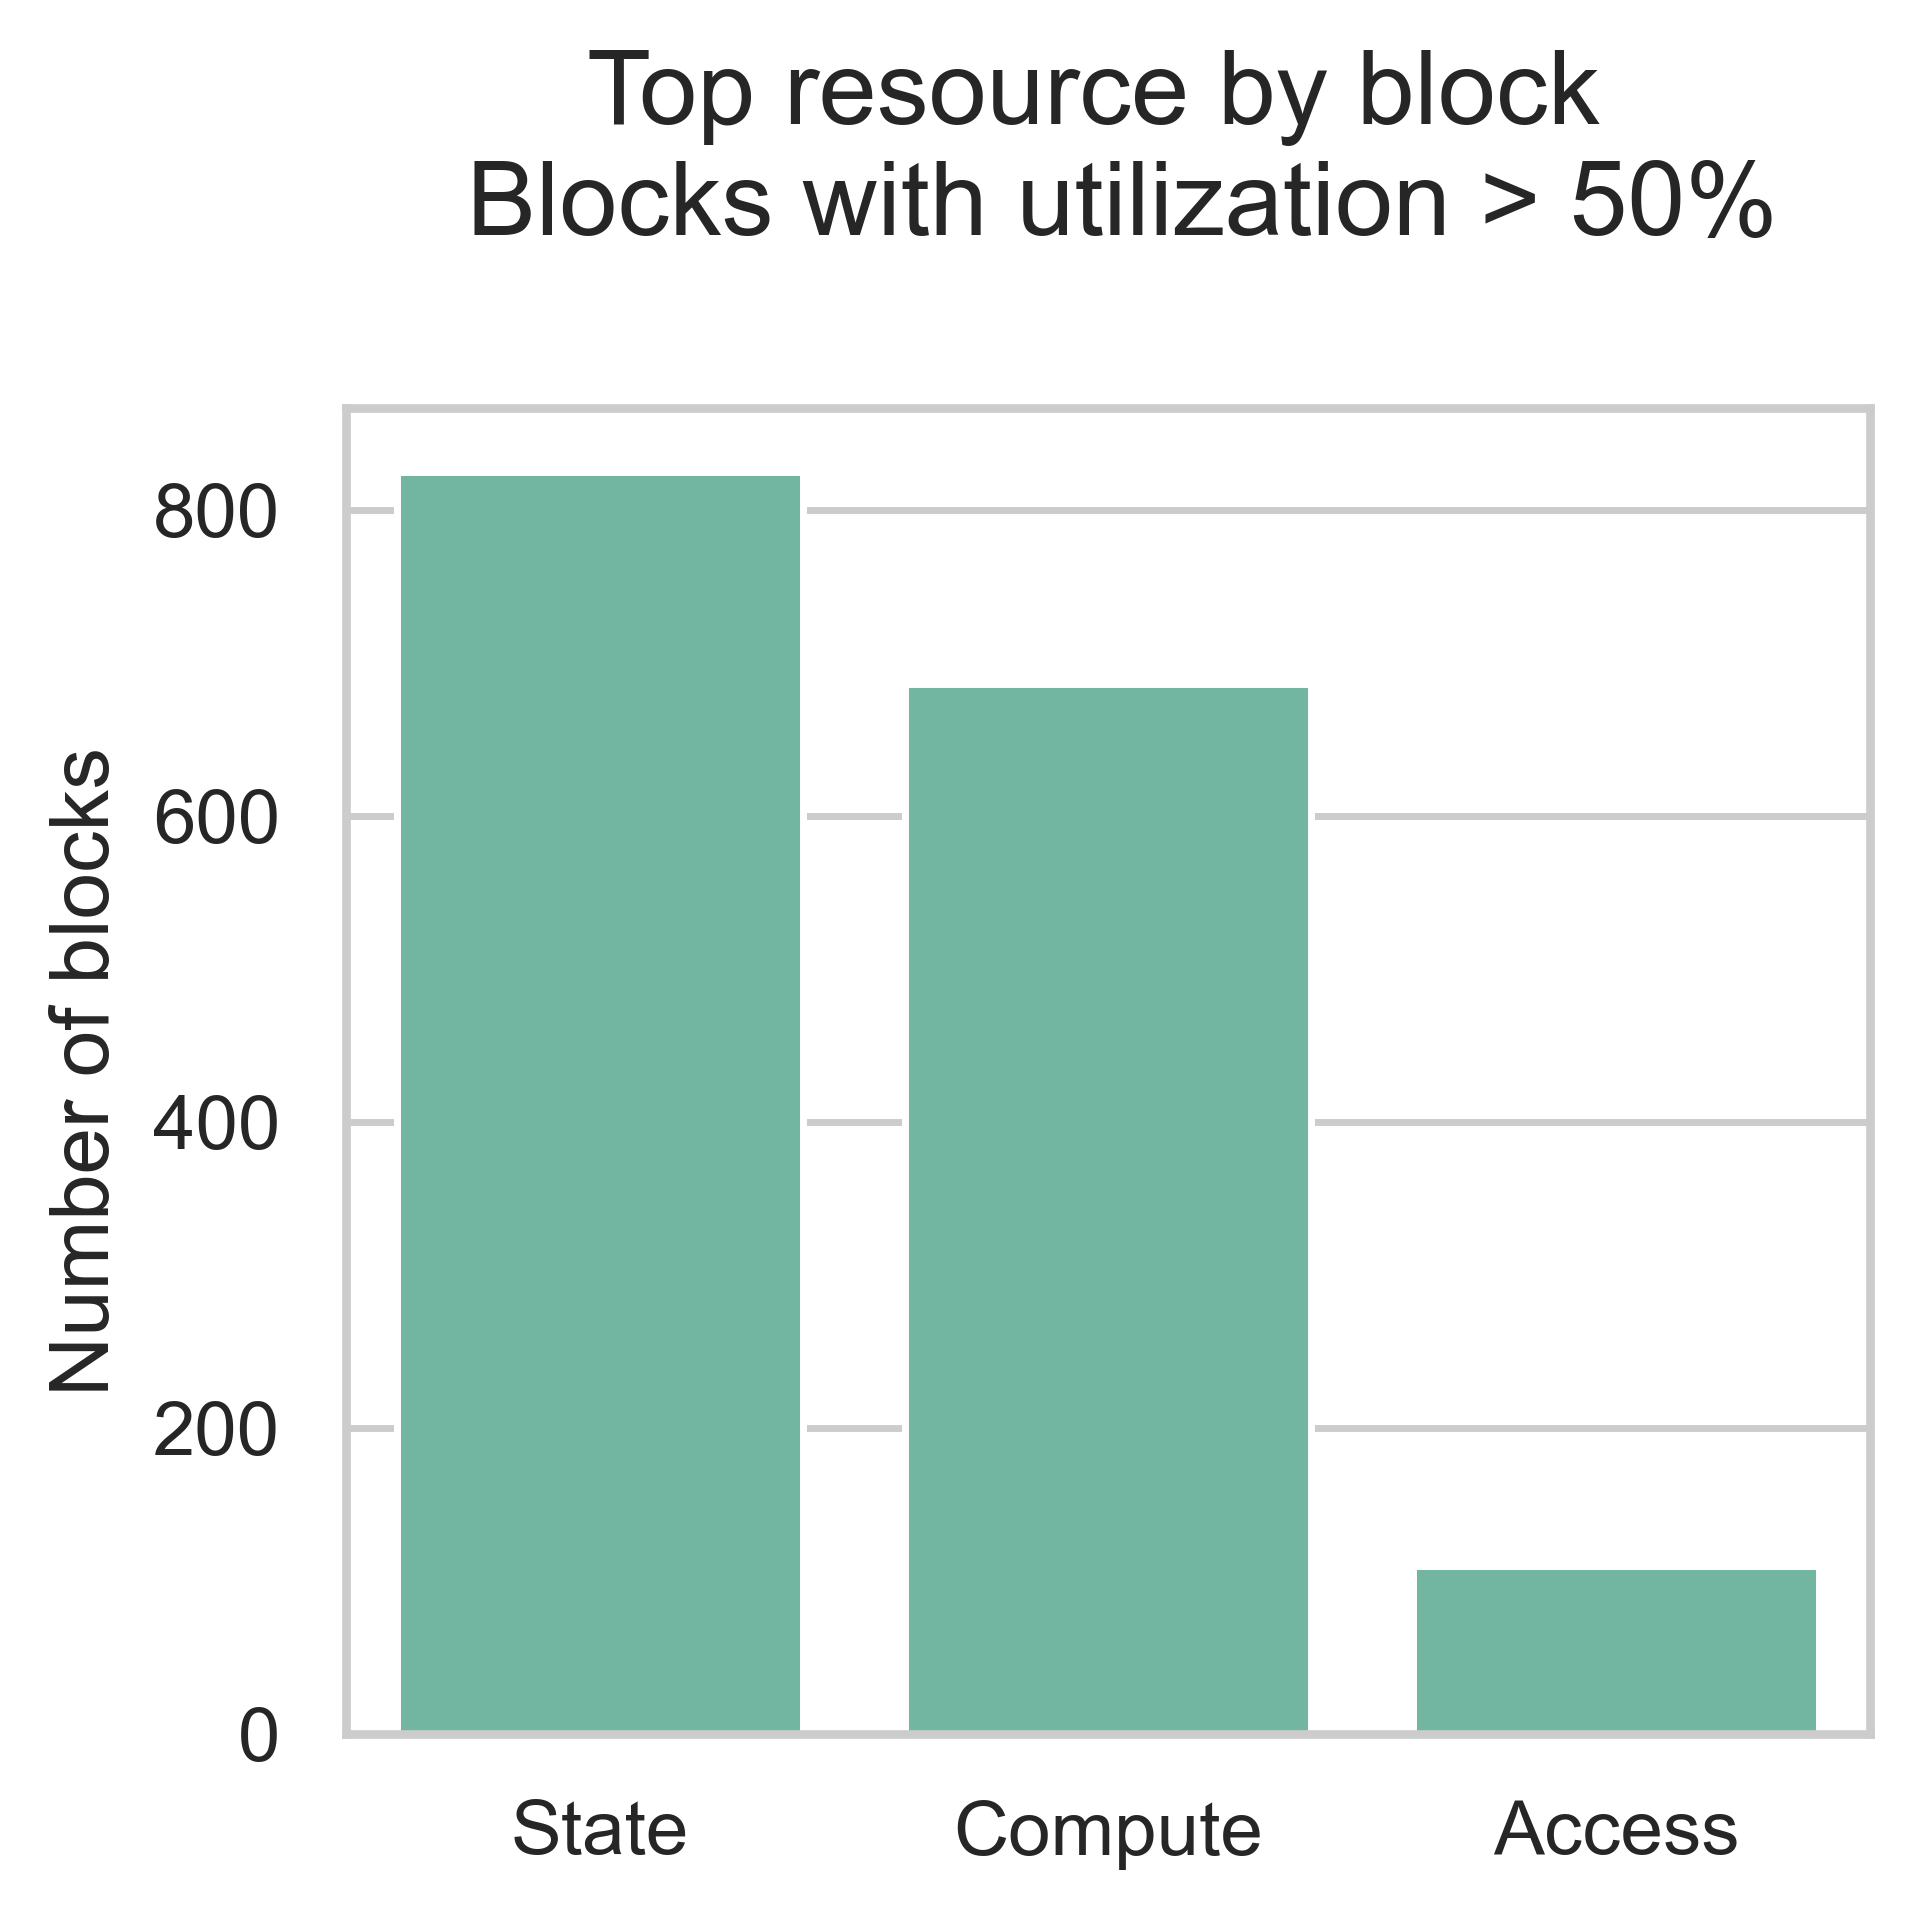

In [30]:
thres = 0.5
top_resource_df = (
    resource_by_block_df[resource_by_block_df["Total"] > thres]
    .drop(columns="Total")
    .reset_index()
    .melt(id_vars=["block_height"], var_name="Resource", value_name="gas_cost")
    .sort_values("gas_cost", ascending=False)
    .groupby("block_height")
    .first()
)
plt.figure(figsize=(4, 4))
sns.countplot(data=top_resource_df, x="Resource")
plt.title(
    f"Top resource by block \n Blocks with utilization > {int(thres*100)}%",
    pad=25,
)
plt.xlabel("")
plt.ylabel("Number of blocks")
plt.tight_layout()
plt.show()

Tx %: 15.54054054054054


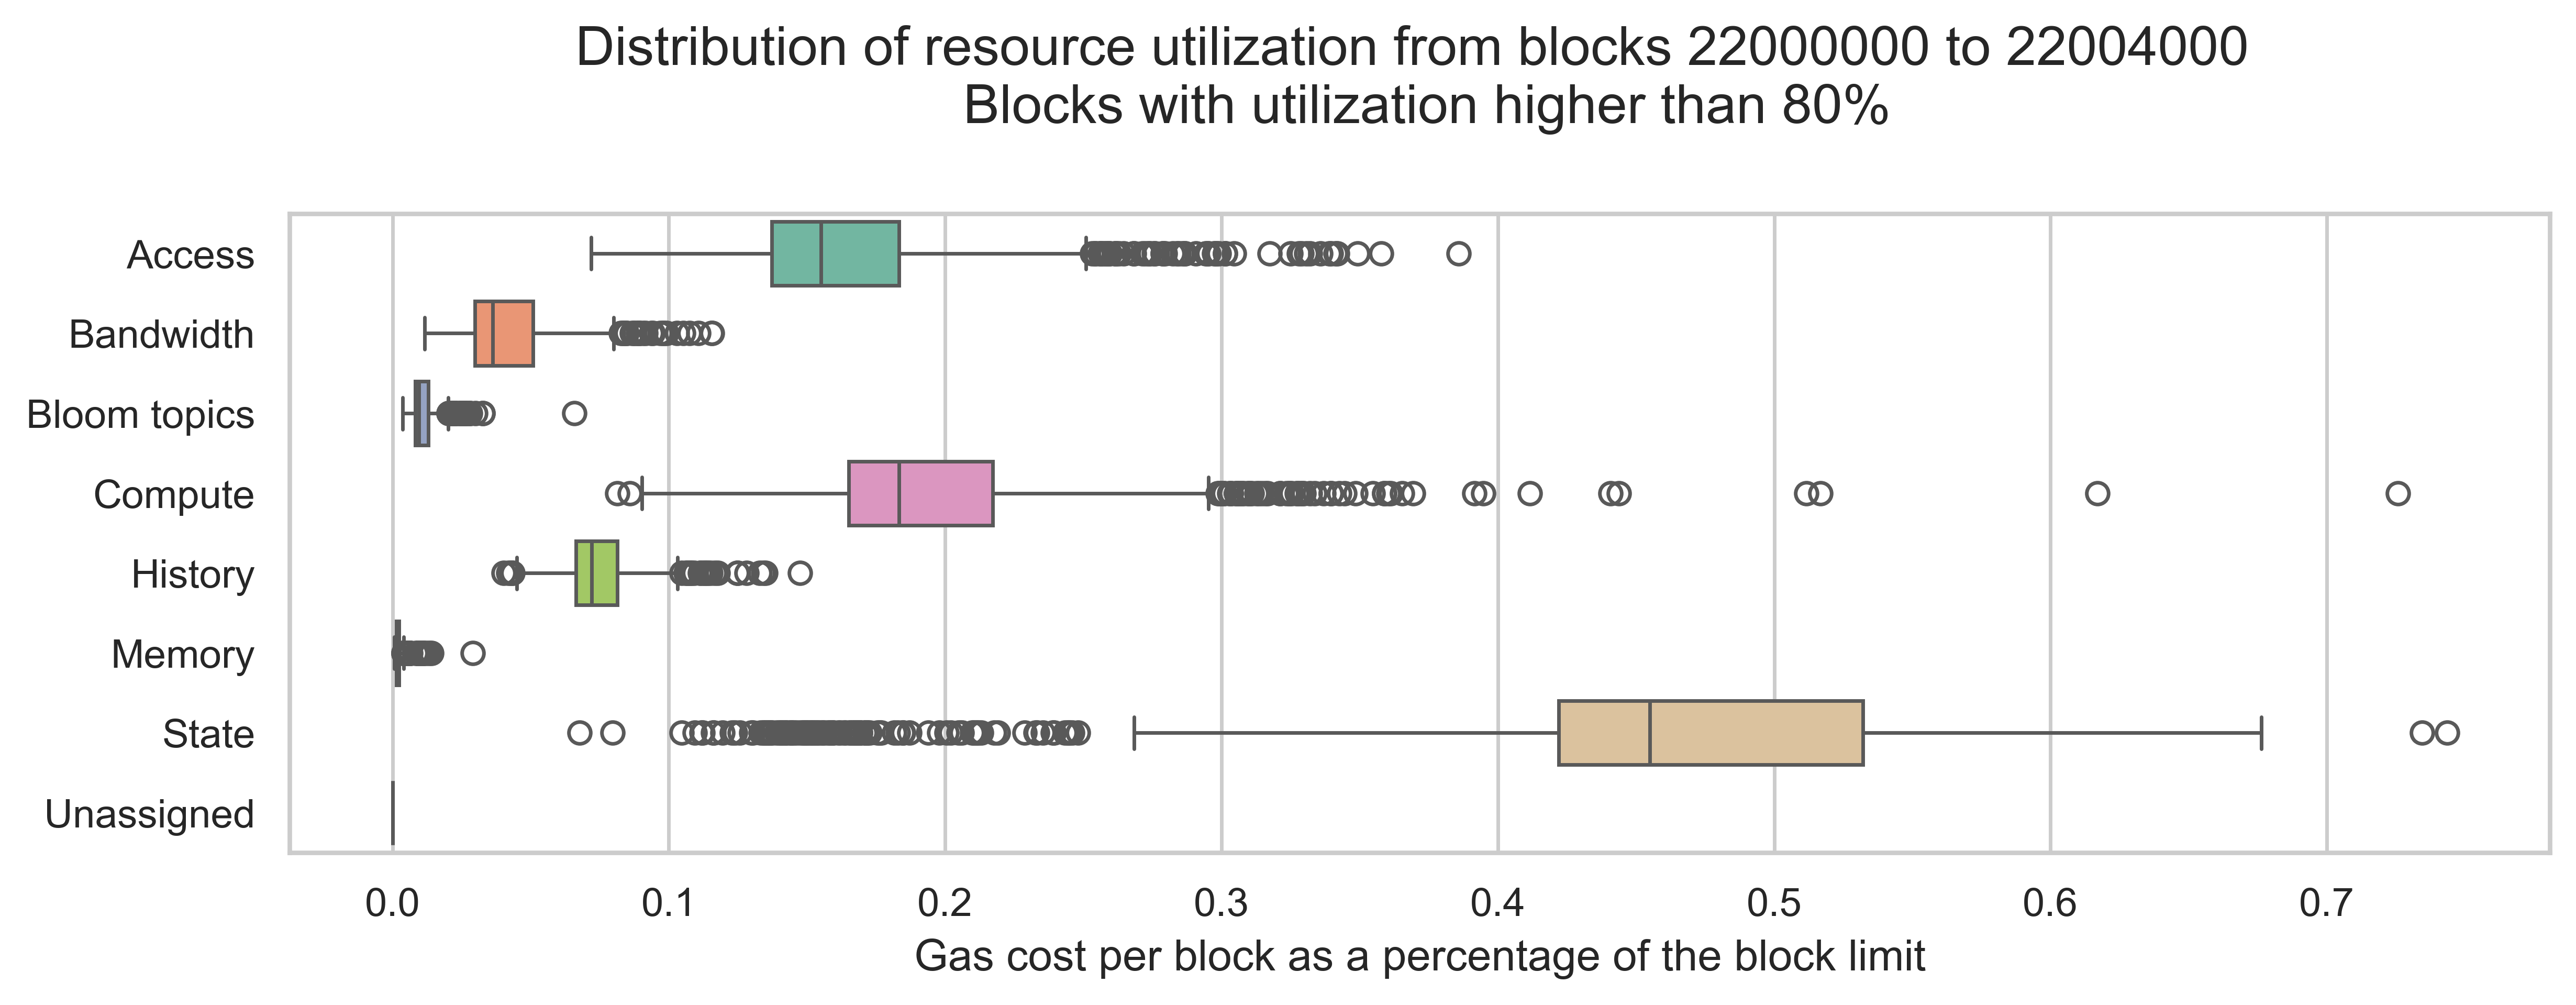

In [31]:
thres = 0.8
high_util_blocks_df = resource_by_block_df[resource_by_block_df["Total"] > thres]
print("Tx %:", 100 * len(high_util_blocks_df) / len(resource_by_block_df))

temp_df = (
    high_util_blocks_df.drop(columns="Total")
    .reset_index()
    .melt(id_vars=["block_height"], var_name="Resource", value_name="gas_cost")
    .sort_values("Resource")
)

plt.figure(figsize=(10, 4))
sns.boxplot(
    y="Resource",
    x="gas_cost",
    data=temp_df,
    hue="Resource",
    legend=False,
)
plt.title(
    f"Distribution of resource utilization from blocks {block_start} to {block_end} \n Blocks with utilization higher than {int(thres*100)}%",
    pad=25,
)
plt.ylabel("")
plt.xlabel("Gas cost per block as a percentage of the block limit")
plt.tight_layout()
plt.show()

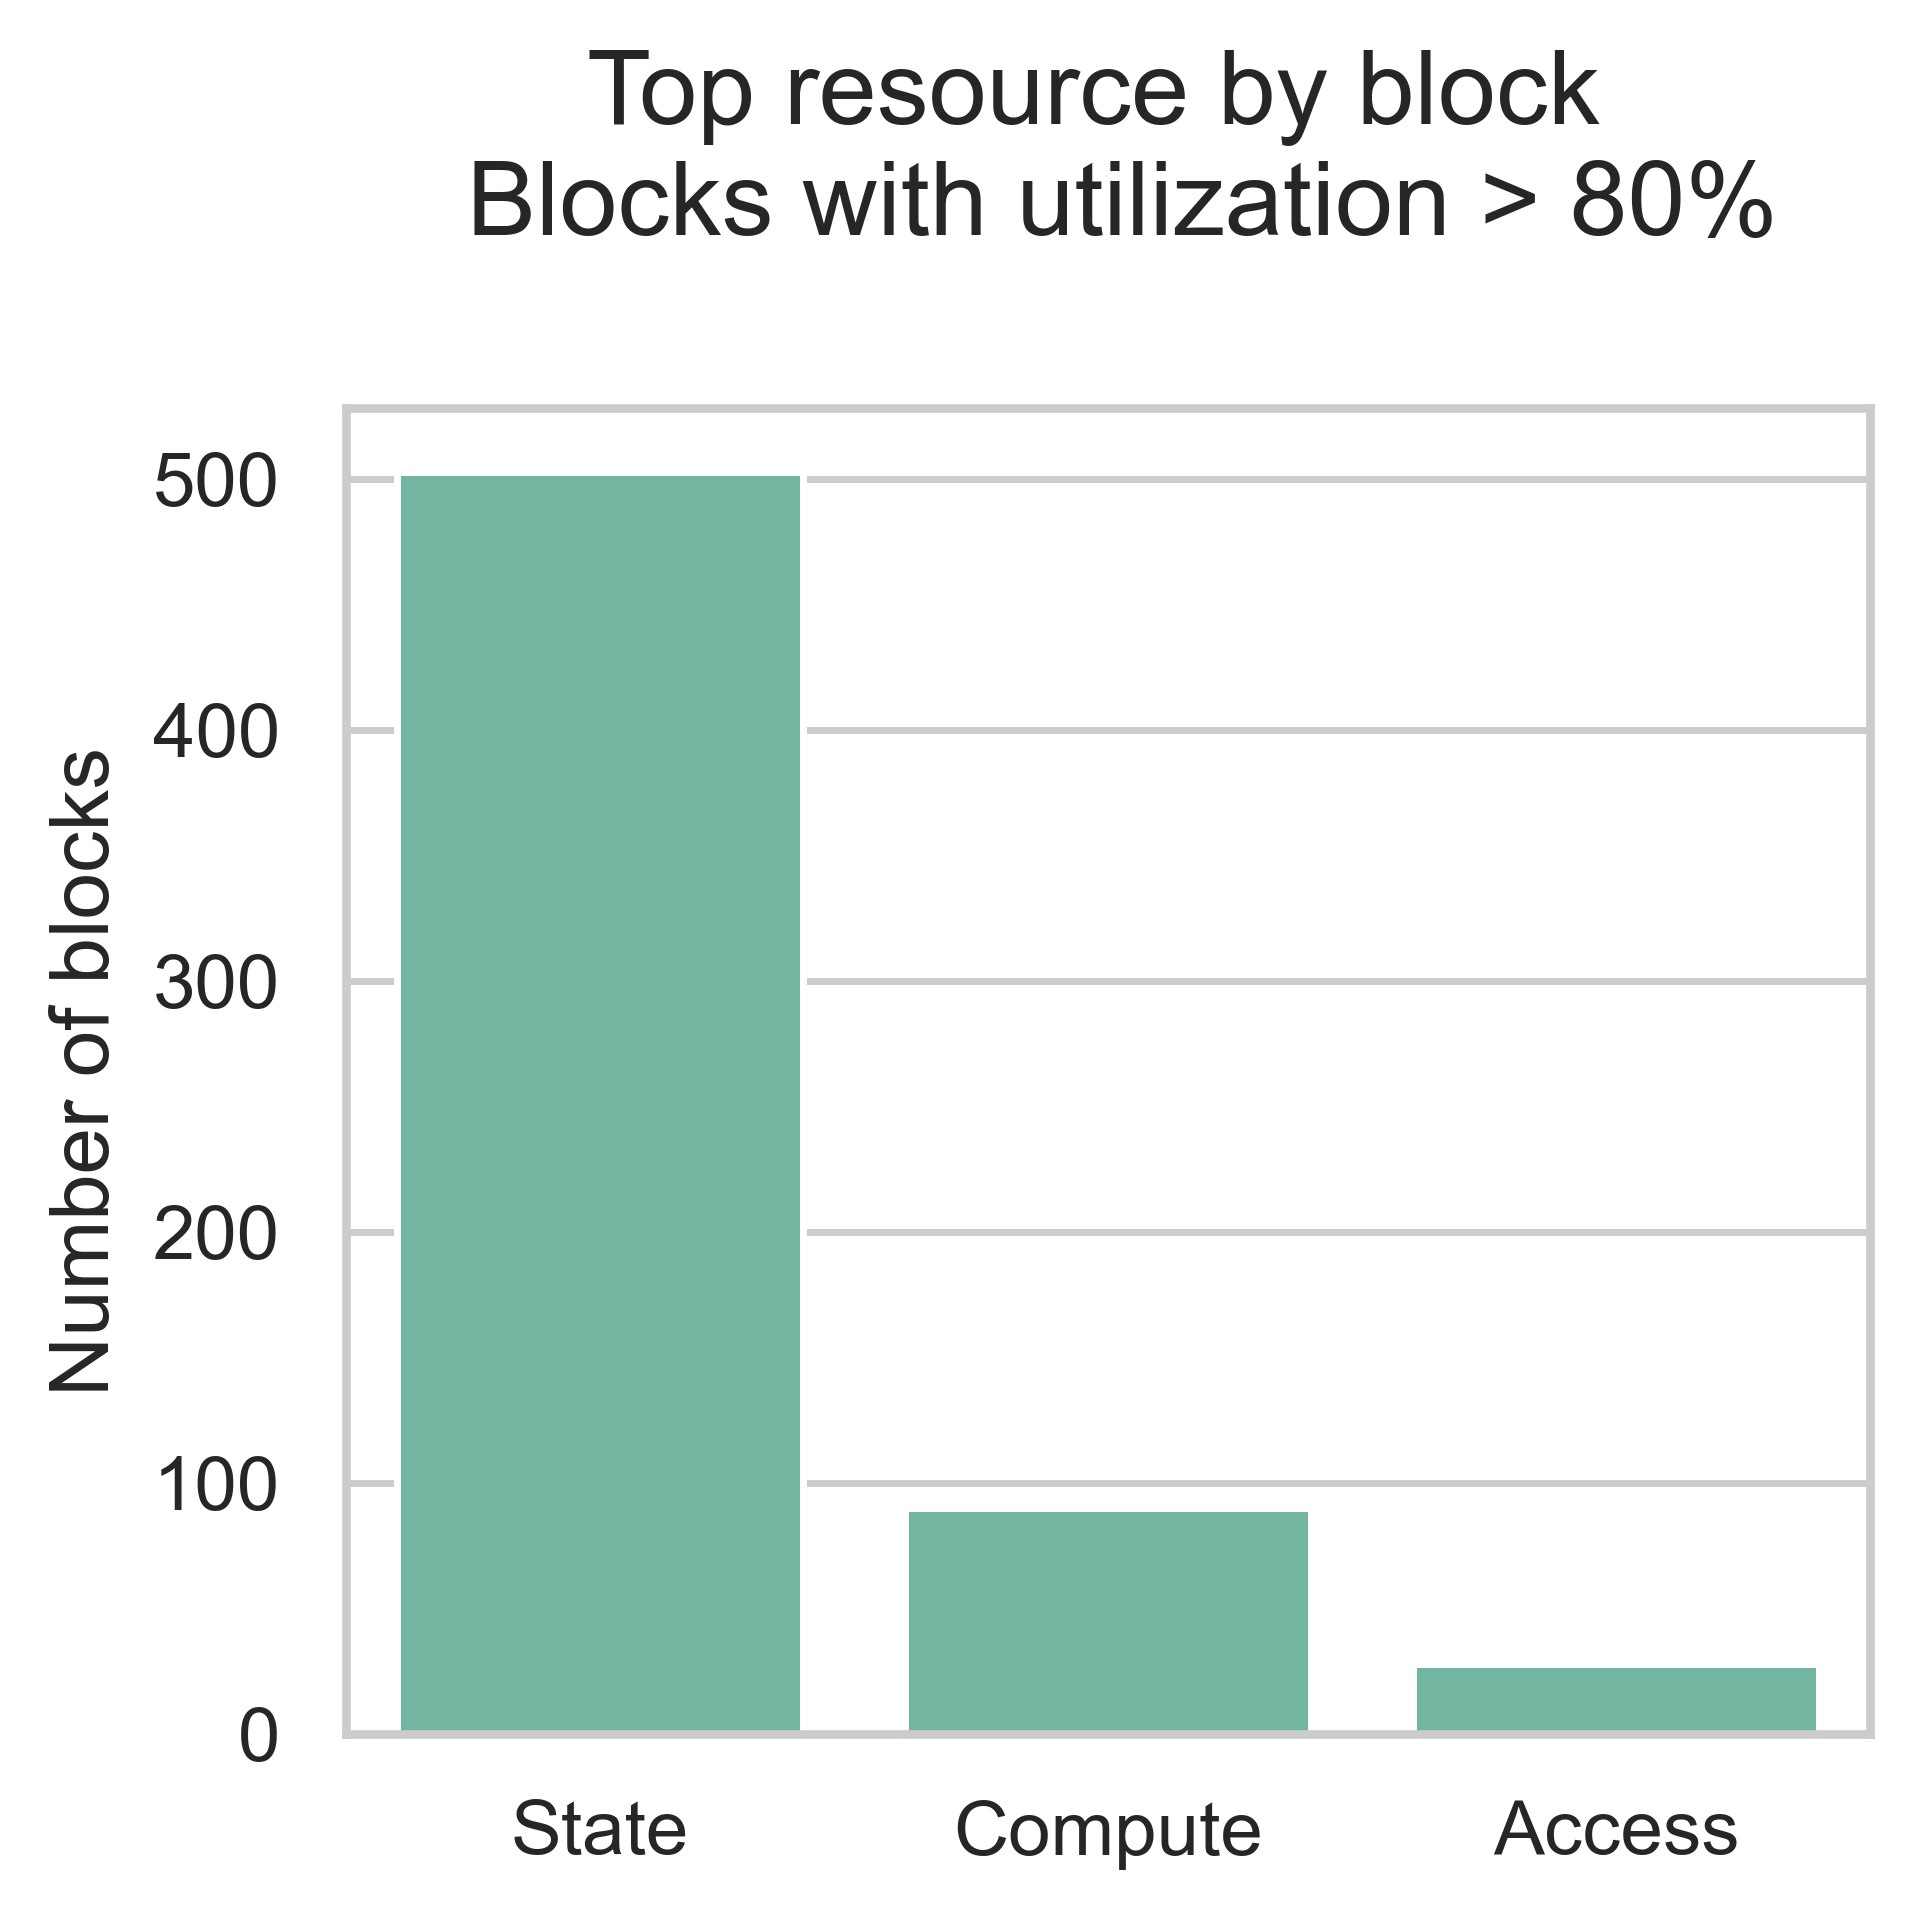

In [32]:
thres = 0.8
top_resource_df = (
    resource_by_block_df[resource_by_block_df["Total"] > thres]
    .drop(columns="Total")
    .reset_index()
    .melt(id_vars=["block_height"], var_name="Resource", value_name="gas_cost")
    .sort_values("gas_cost", ascending=False)
    .groupby("block_height")
    .first()
)
plt.figure(figsize=(4, 4))
sns.countplot(data=top_resource_df, x="Resource")
plt.title(
    f"Top resource by block \n Blocks with utilization > {int(thres*100)}%",
    pad=25,
)
plt.xlabel("")
plt.ylabel("Number of blocks")
plt.tight_layout()
plt.show()

Tx %: 8.208208208208209


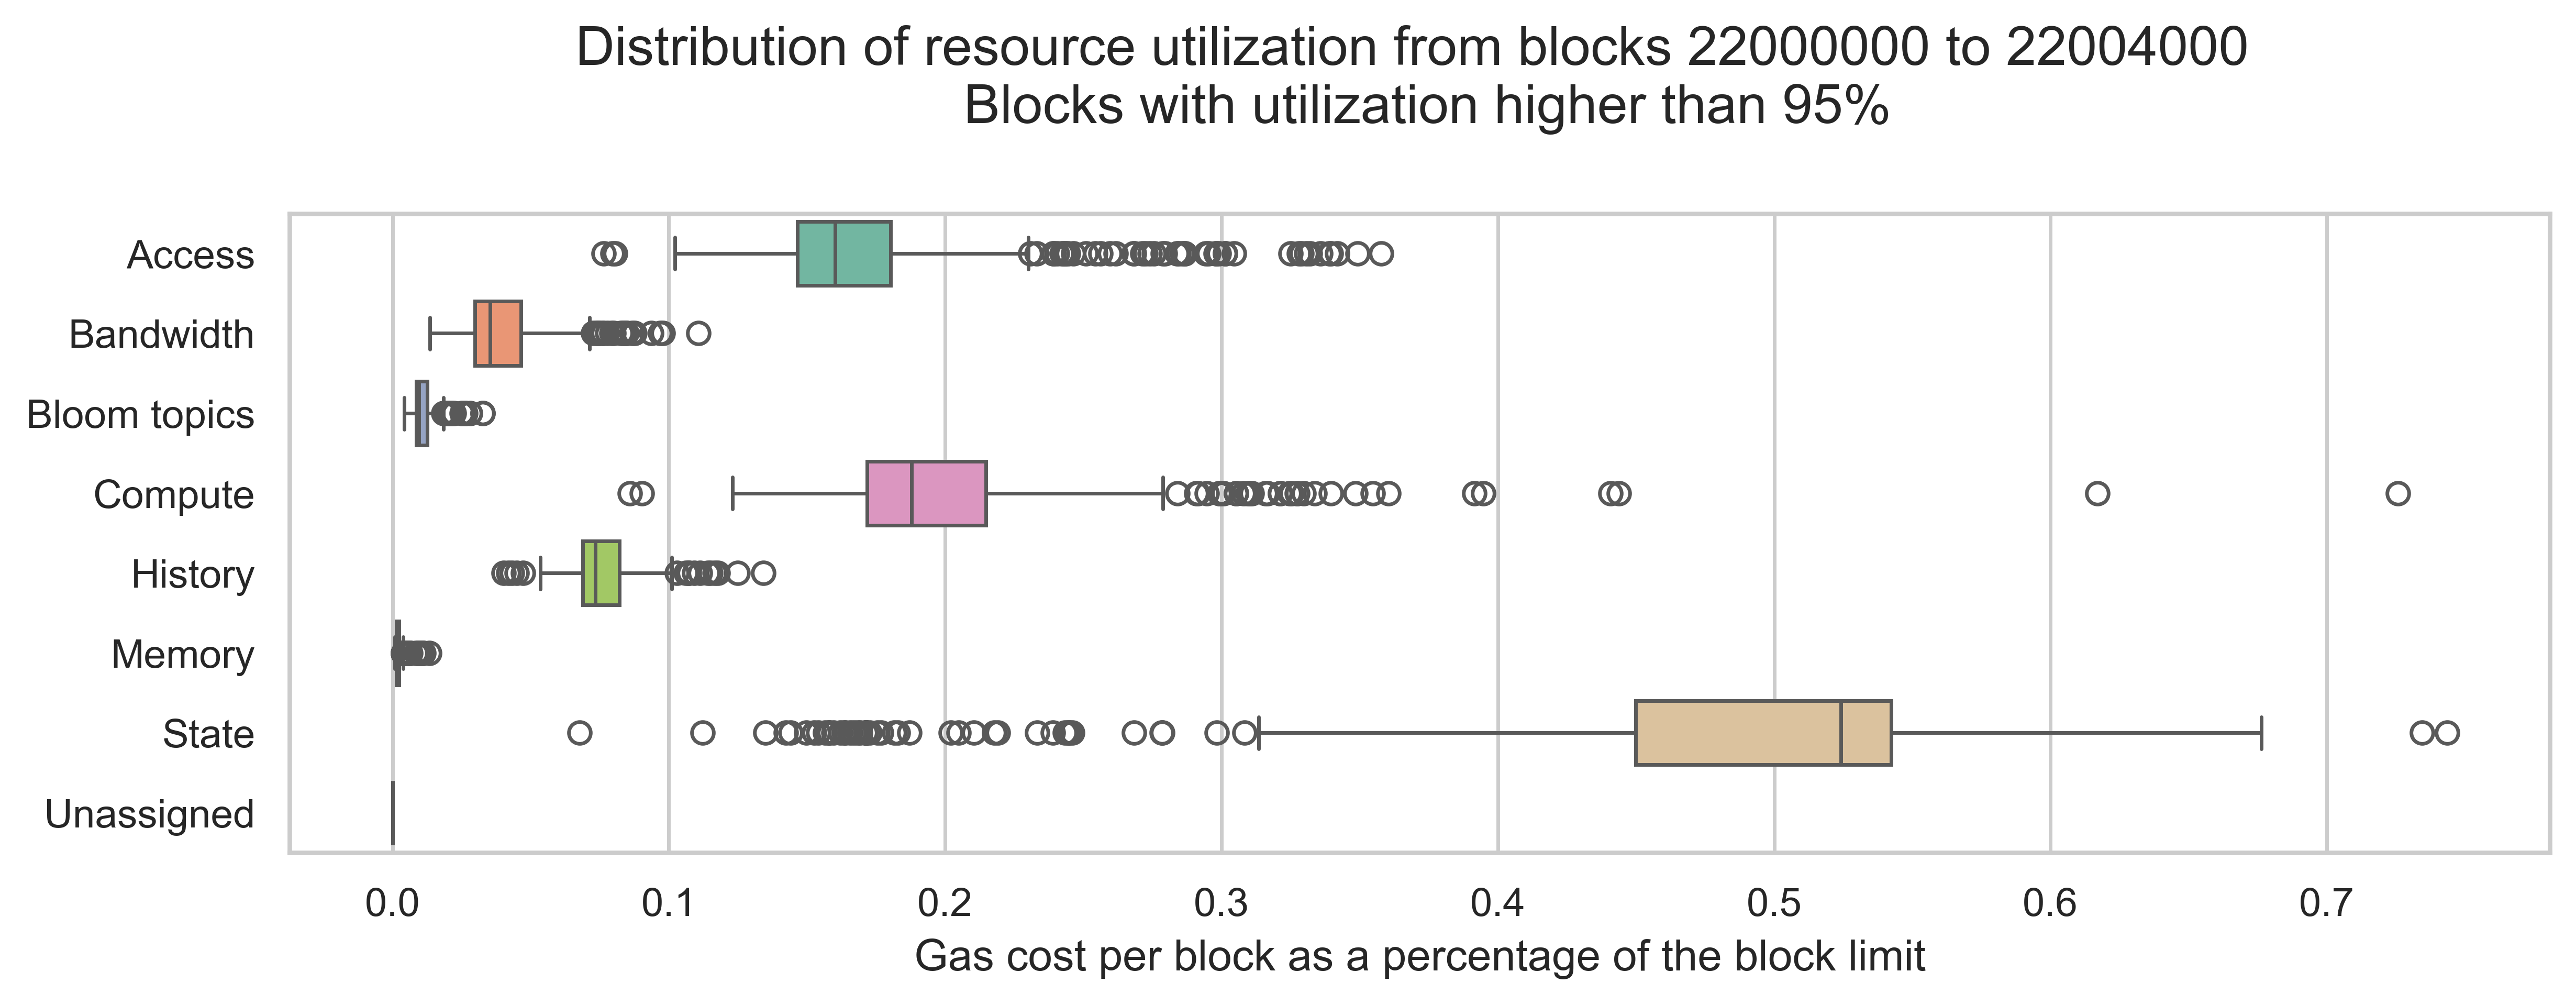

In [33]:
thres = 0.95
high_util_blocks_df = resource_by_block_df[resource_by_block_df["Total"] > thres]
print("Tx %:", 100 * len(high_util_blocks_df) / len(resource_by_block_df))

temp_df = (
    high_util_blocks_df.drop(columns="Total")
    .reset_index()
    .melt(id_vars=["block_height"], var_name="Resource", value_name="gas_cost")
    .sort_values("Resource")
)

plt.figure(figsize=(10, 4))
sns.boxplot(
    y="Resource",
    x="gas_cost",
    data=temp_df,
    hue="Resource",
    legend=False,
)
plt.title(
    f"Distribution of resource utilization from blocks {block_start} to {block_end} \n Blocks with utilization higher than {int(thres*100)}%",
    pad=25,
)
plt.ylabel("")
plt.xlabel("Gas cost per block as a percentage of the block limit")
plt.tight_layout()
plt.show()

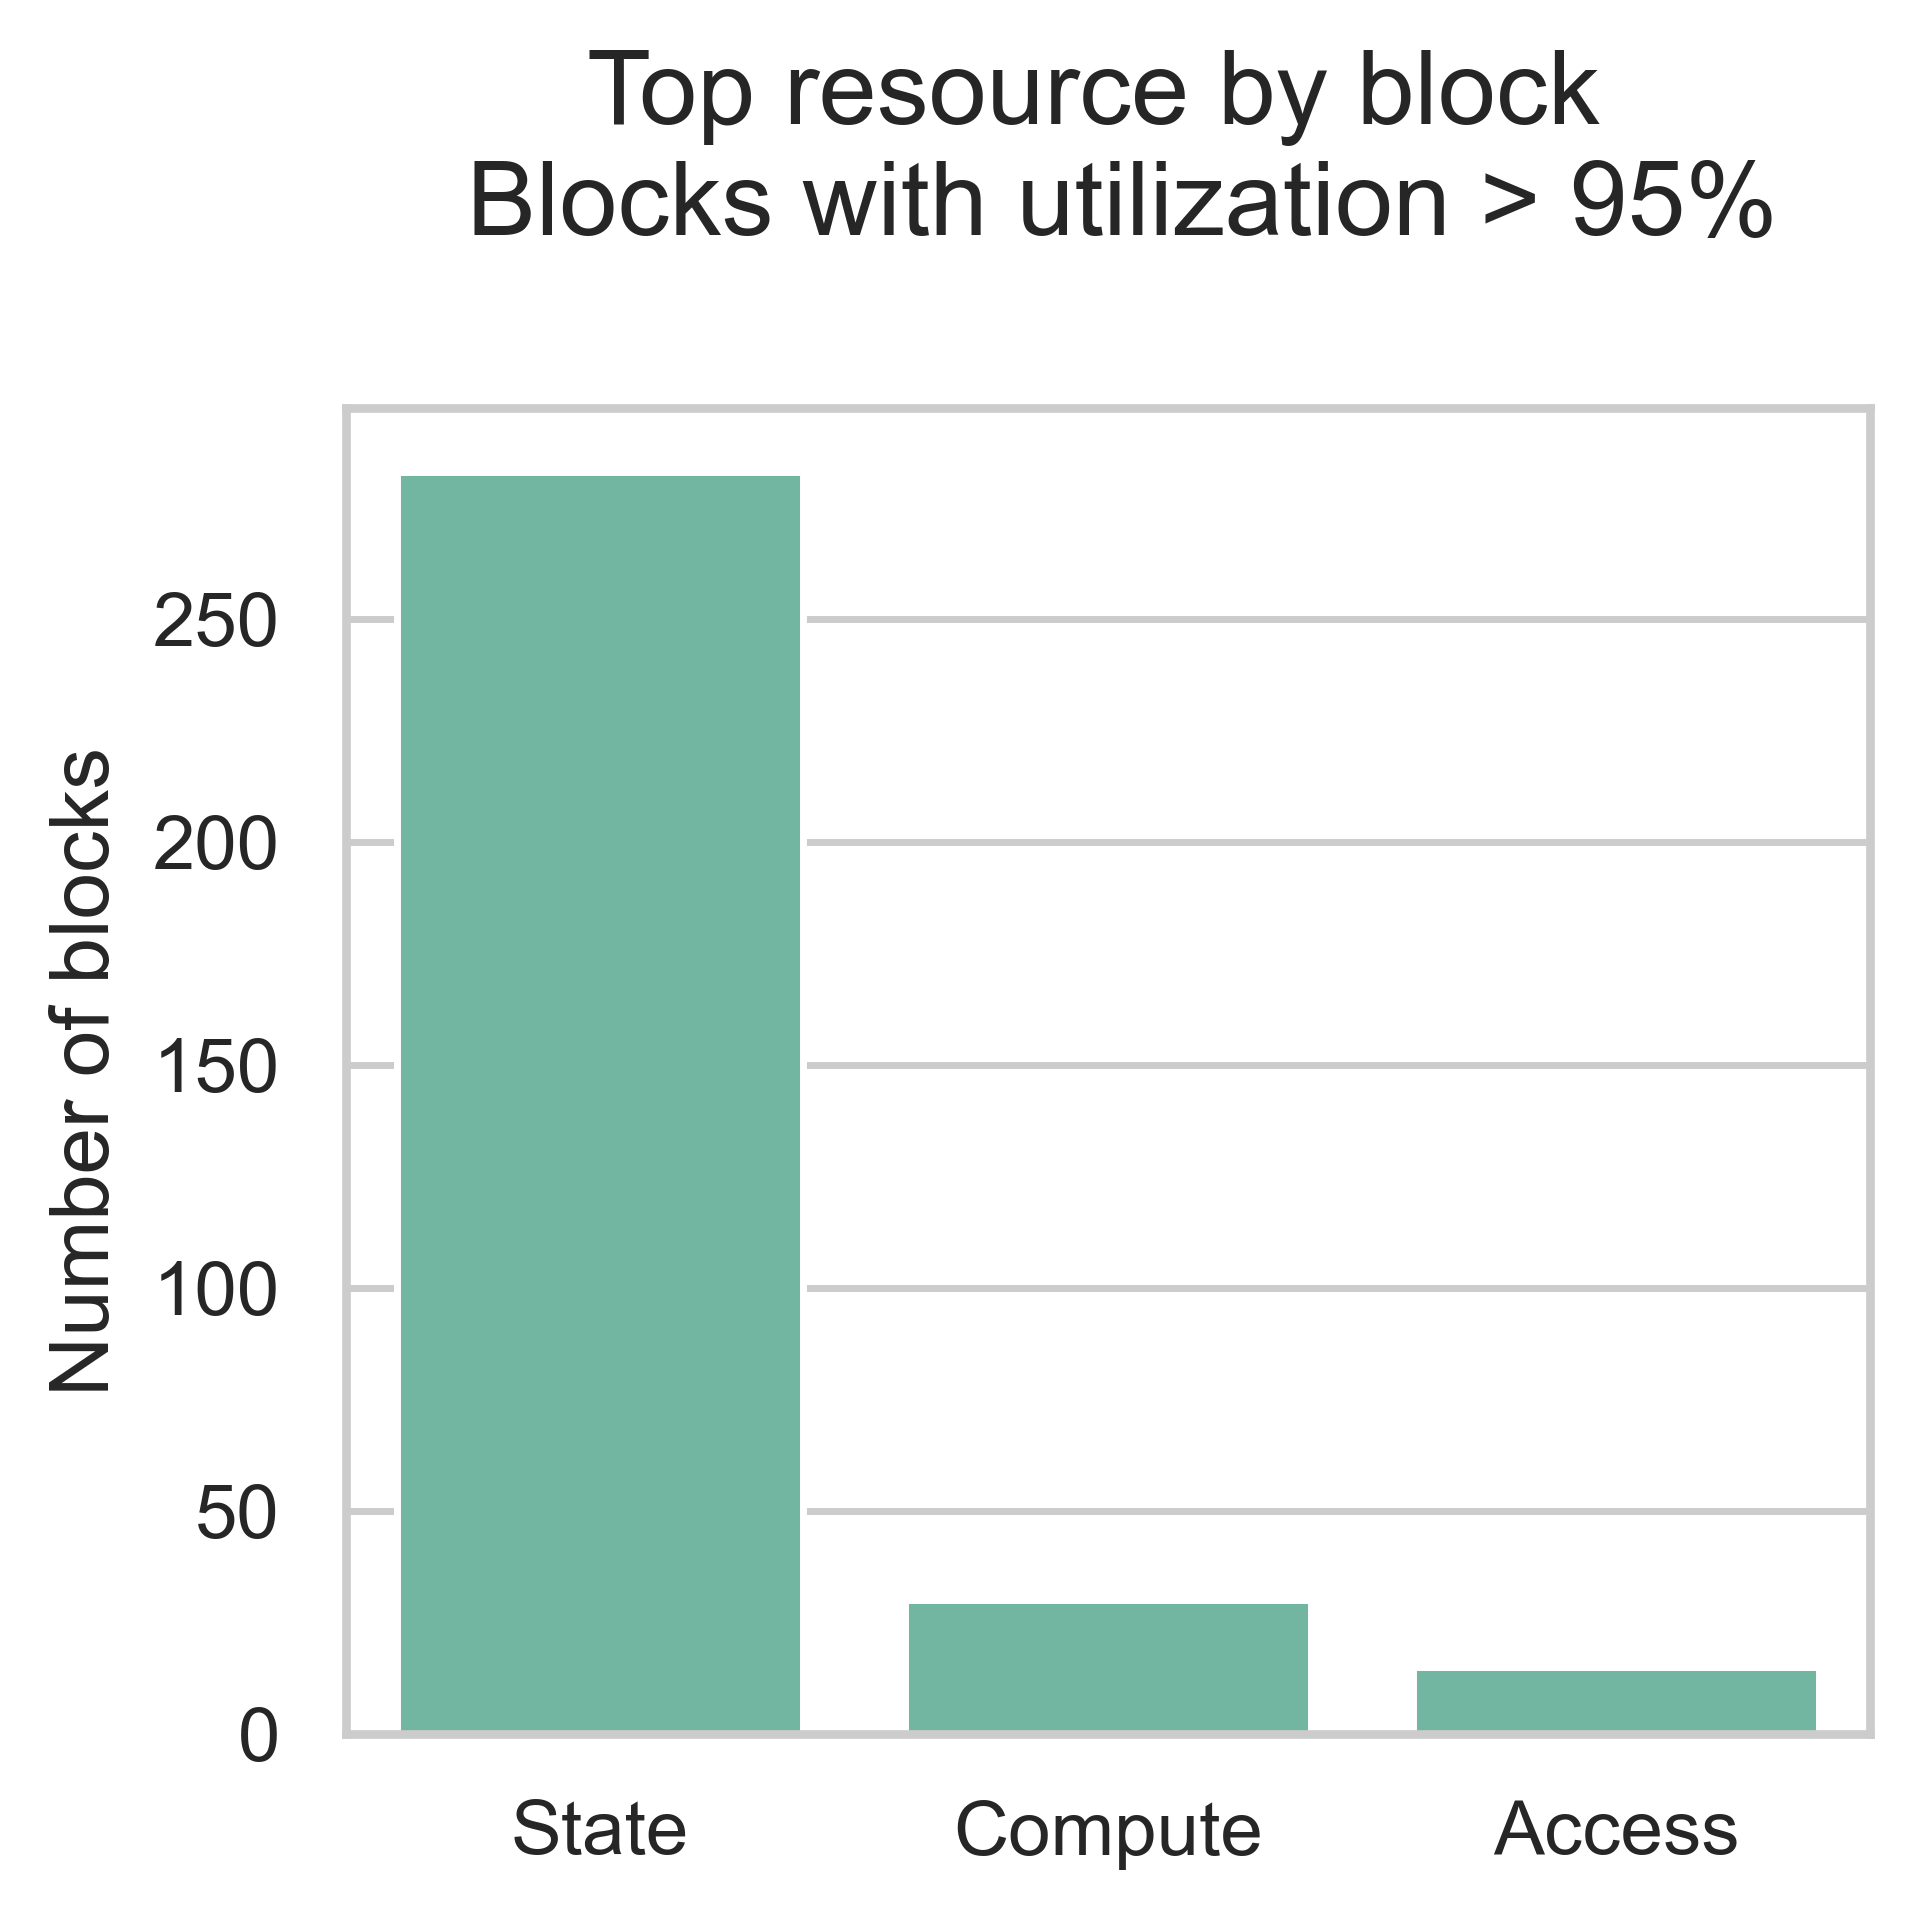

In [34]:
thres = 0.95
top_resource_df = (
    resource_by_block_df[resource_by_block_df["Total"] > thres]
    .drop(columns="Total")
    .reset_index()
    .melt(id_vars=["block_height"], var_name="Resource", value_name="gas_cost")
    .sort_values("gas_cost", ascending=False)
    .groupby("block_height")
    .first()
)
plt.figure(figsize=(4, 4))
sns.countplot(data=top_resource_df, x="Resource")
plt.title(
    f"Top resource by block \n Blocks with utilization > {int(thres*100)}%",
    pad=25,
)
plt.xlabel("")
plt.ylabel("Number of blocks")
plt.tight_layout()
plt.show()

In [36]:
resource_by_block_df

Compute    Access    Memory   History  Bloom topics     State  \
block_height                                                                   
22000000.0    0.069153  0.066357  0.001068  0.034286      0.004153  0.321736   
22000001.0    0.184494  0.076664  0.009170  0.057535      0.007437  0.053675   
22000002.0    0.090882  0.078541  0.001390  0.035124      0.004812  0.260923   
22000003.0    0.110531  0.083267  0.000668  0.045757      0.005146  0.061550   
22000004.0    0.073215  0.052401  0.001115  0.043842      0.004139  0.511786   
...                ...       ...       ...       ...           ...       ...   
22003996.0    0.161680  0.158137  0.001337  0.065081      0.007542  0.530820   
22003997.0    0.086549  0.065096  0.001029  0.029916      0.005604  0.048641   
22003998.0    0.143102  0.094760  0.001202  0.048618      0.006417  0.074377   
22003999.0    0.155370  0.122934  0.001282  0.059599      0.007653  0.422910   
22004000.0    0.084917  0.073954  0.000621  0.034044      0.004653  0.052633   

              Bandwidth  Unassigned     Total  
block_height                                   
22000000.0     0.034791         0.0  0.531544  
22000001.0     0.062727         0.0  0.451702  
22000002.0     0.032079         0.0  0.503752  
22000003.0     0.036519         0.0  0.343438  
22000004.0     0.035929         0.0  0.722427  
...                 ...         ...       ...  
22003996.0     0.028014         0.0  0.952611  
22003997.0     0.021782         0.0  0.258616  
22003998.0     0.042715         0.0  0.411190  
22003999.0     0.027122         0.0  0.796870  
22004000.0     0.025720         0.0  0.276543  

[3996 rows x 9 columns]

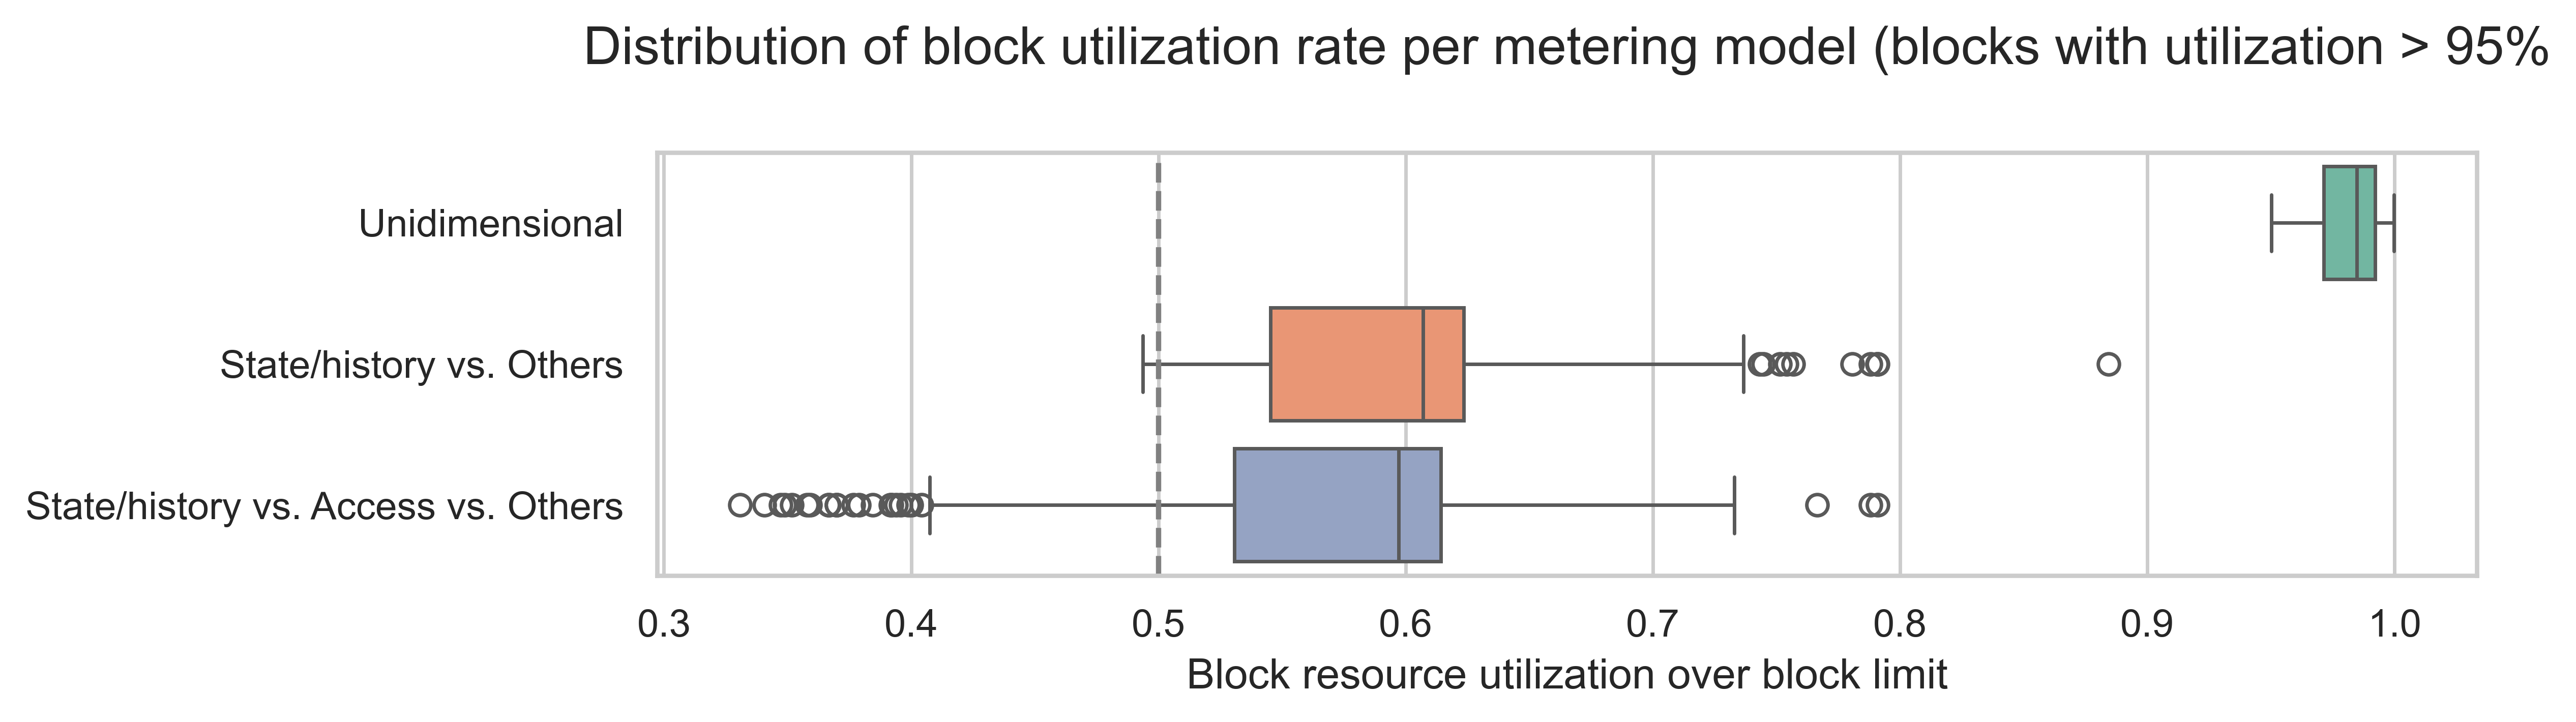

In [41]:
thres = 0.95
top_resource_blocks = resource_by_block_df[resource_by_block_df["Total"] > thres].index.values.tolist()

plt.figure(figsize=(10, 3))
sns.boxplot(
    data=util_melt_df[util_melt_df["block_height"].isin(top_resource_blocks)],
    x="perc_over_limit",
    y="meter",
    hue="meter",
    legend=False,
)
plt.axvline(x=0.5, color="grey", linestyle="--")
plt.xlabel("Block resource utilization over block limit")
plt.ylabel("")
plt.title(
    f"Distribution of block utilization rate per metering model (blocks with utilization > {int(thres*100)}%",
    pad=25,
)
plt.tight_layout()
plt.show()